## Connecting to colab

In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, probplot
from scipy import stats


sns.set(style="whitegrid")

## Loading data and preprocessing

In [3]:
# ---- Loading in the data -----
df_train = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_add.xlsx')
df_val = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data_add.xlsx')
df_test = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_test_data_add.xlsx')


In [ ]:
# ---- Checking missing values ----
missing_values = df_train.isna().sum()
missing_values

trading_day        0
IWSS_Equal         0
IWSS_Ratio         0
IWSS_Impurity      0
IWSS_perm          0
IWSS_SHAP          0
IWSS_metric        0
IWSS_PCA           0
Sentiment_score    0
Date               0
Close              0
High               0
Low                0
Open               0
Volume             0
VIX                0
return_t           1
return_t+1         0
dtype: int64

In [11]:
df_train = df_train.dropna(subset=['return_t'])
df_train['trading_day'] = pd.to_datetime(df_train['trading_day'])

<ipython-input-11-fe7202b4425a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trading_day'] = pd.to_datetime(df_train['trading_day'])


## Defining features

In [12]:
base_features = ['return_t', 'Volume', 'VIX']
sentiment_features = ['IWSS_Equal', 'IWSS_Ratio', 'IWSS_Impurity', 'IWSS_perm',
                      'IWSS_SHAP', 'IWSS_metric', 'IWSS_PCA', 'Sentiment_score']
all_features = base_features + sentiment_features
target = 'return_t+1'

## Correlation Heatmaps

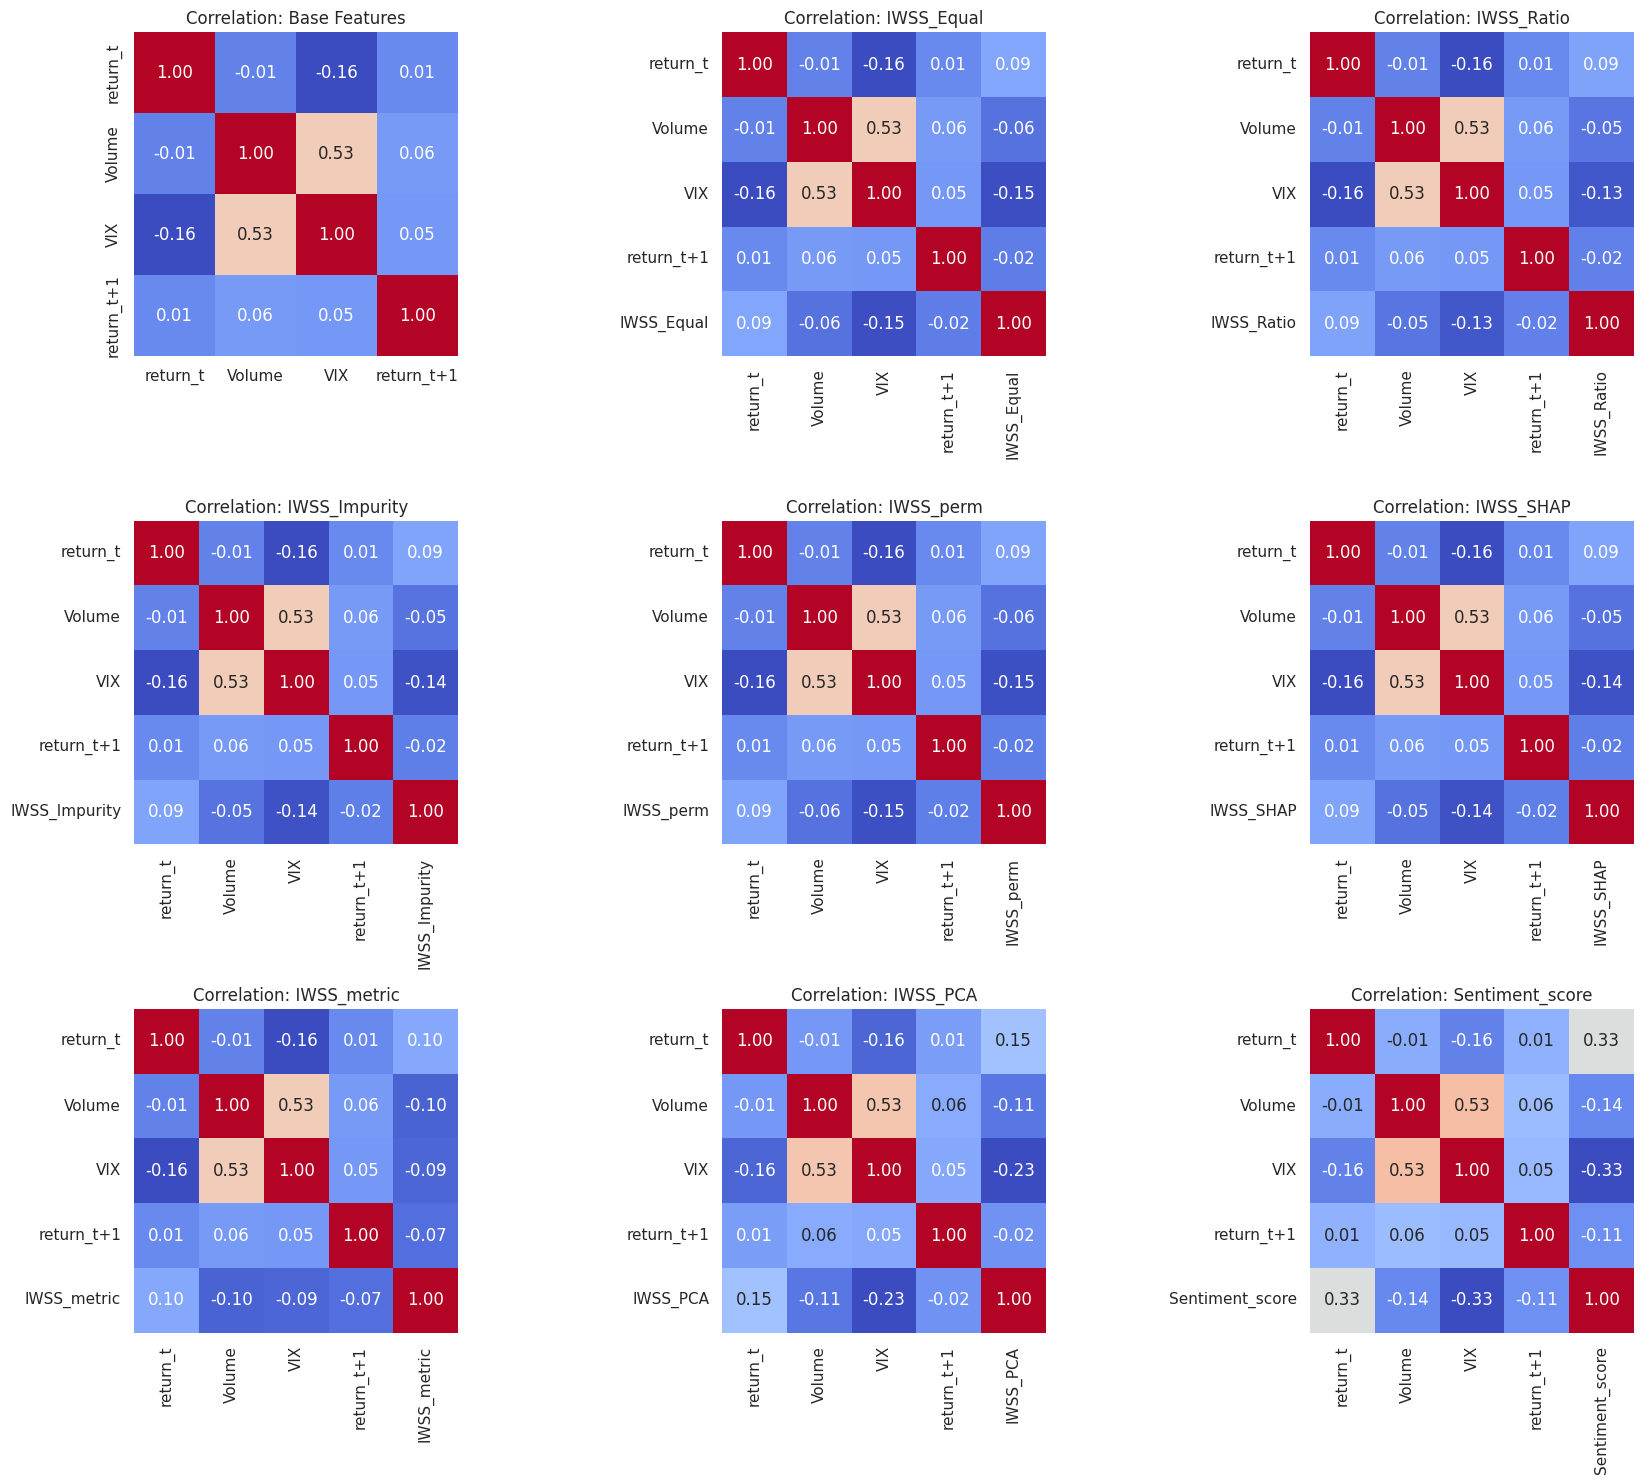

In [ ]:
feature_sets = [base_features + [target]] + [base_features + [target, feat] for feat in sentiment_features]
titles = ['Base Features'] + sentiment_features

n_cols = 3
n_rows = -(-len(feature_sets) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))

for idx, (features_subset, title) in enumerate(zip(feature_sets, titles)):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col] if n_rows > 1 else axes[col]
    corr_matrix = df_train[features_subset].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, ax=ax, cbar=False)
    ax.set_title(f'Correlation: {title}')

for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


Base features:
- strongest correlation is between VIX and Volume (0.53)
- there seems to be quite low autocorrelation looking at return_t and return_t+1 are not very correlated.

IWSS methods:
- All IVSS features show low correlations with return_t+1, often near zero or slightly negative.

- They are moderately correlated with VIX (mostly negative), especially for IVSS_PCA (-0.23) and IVSS_metric (-0.20).

Sentiment score:
- Shows the highest correlation with return_t+1 (0.33) compared to all other features.

- Also moderately correlated with return_t (0.33), suggesting some persistence in sentiment and its influence on returns.

- Minimal correlation with Volume and VIX.


It seems there is the strongest linear correlation with sentiment_score.

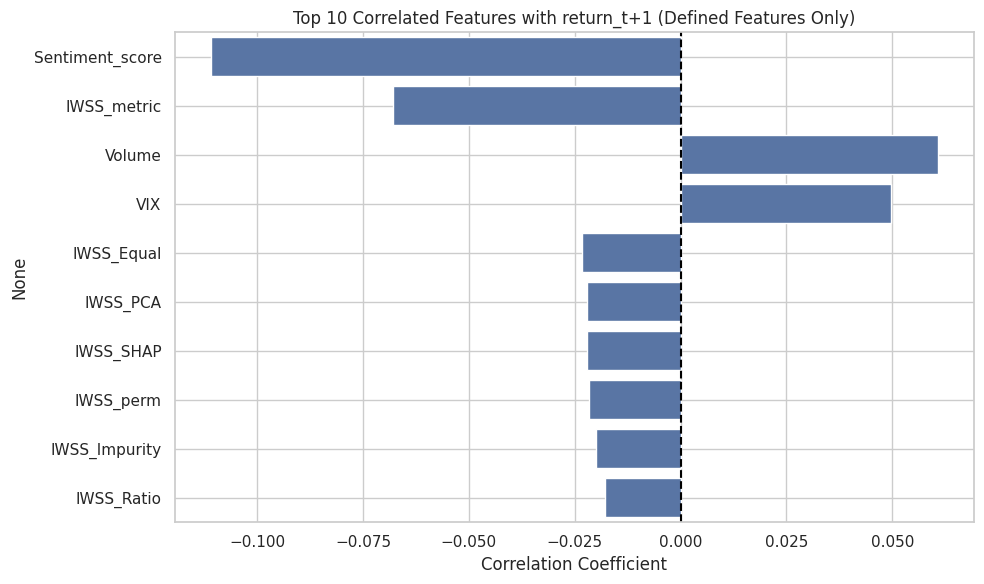

Top 10 features by absolute correlation (within defined feature set):


Correlation
Sentiment_score    -0.110850
IWSS_metric        -0.067891
Volume              0.060703
VIX                 0.049598
IWSS_Equal         -0.023269
IWSS_PCA           -0.022137
IWSS_SHAP          -0.022071
IWSS_perm          -0.021538
IWSS_Impurity      -0.020066
IWSS_Ratio         -0.017893

In [ ]:
# Subset the DataFrame to only the defined features + target
feature_subset = df_train[all_features + [target]].dropna()

# Compute correlations with the target
correlations = feature_subset.corr(numeric_only=True)[target].drop(target)

# Get top 10 absolute correlations (within defined features)
top_features = correlations.abs().sort_values(ascending=False).head(10)
top_features_signed = correlations.loc[top_features.index]  # retain sign

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features_signed.values, y=top_features_signed.index)
plt.title("Top 10 Correlated Features with return_t+1 (Defined Features Only)")
plt.xlabel("Correlation Coefficient")
plt.axvline(x=0, linestyle='--', color='black')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Display Table ---
print("Top 10 features by absolute correlation (within defined feature set):")
display(top_features_signed.to_frame(name='Correlation'))


## Investigating skewness

In [ ]:
df_train.describe()

trading_day   IWSS_Equal   IWSS_Ratio  IWSS_Impurity  \
count                            459   459.000000   459.000000     459.000000   
mean   2022-12-02 16:03:08.235293952    48.418719    92.644665      62.374684   
min              2022-01-04 00:00:00 -1824.465430 -3511.819090   -2345.858340   
25%              2022-06-19 00:00:00  -111.829059  -170.794920    -129.190421   
50%              2022-12-01 00:00:00    15.697252    27.489732      21.620823   
75%              2023-05-17 12:00:00   136.697578   242.529012     171.256231   
max              2023-10-31 00:00:00  4781.351210  8028.486252    5795.830075   
std                              NaN   527.253867   894.686828     639.663075   

         IWSS_perm    IWSS_SHAP  IWSS_metric    IWSS_PCA  Sentiment_score  \
count   459.000000   459.000000   459.000000  459.000000       459.000000   
mean     55.599916    58.306677     0.016177    0.383267         0.002906   
min   -2093.464664 -2208.100976    -1.985019  -52.155467        -0.439101   
25%    -121.096719  -124.257733    -0.054641   -3.575636        -0.086561   
50%      19.253044    20.195823     0.010510    0.332494         0.005119   
75%     153.915062   162.947756     0.083682    3.834869         0.092240   
max    5304.016790  5513.212455     1.020686   94.866833         0.823778   
std     585.001464   609.755361     0.251313   11.792375         0.143990   

                                Date        Close         High          Low  \
count                            459   459.000000   459.000000   459.000000   
mean   2022-12-02 16:03:08.235293952  4155.774819  4185.356229  4124.416660   
min              2022-01-04 00:00:00  3577.030029  3608.340088  3491.580078   
25%              2022-06-19 00:00:00  3958.209961  3980.884888  3927.114990   
50%              2022-12-01 00:00:00  4137.040039  4159.770020  4109.180176   
75%              2023-05-17 12:00:00  4379.334961  4408.929932  4347.435059   
max              2023-10-31 00:00:00  4793.540039  4818.620117  4774.270020   
std                              NaN   260.679484   257.837914   263.902238   

              Open        Volume         VIX    return_t  return_t+1  
count   459.000000  4.590000e+02  459.000000  459.000000  459.000000  
mean   4156.263611  4.348907e+09   21.966275   -0.000213   -0.000189  
min    3520.370117  1.706460e+09   12.820000   -0.043237   -0.043237  
25%    3958.530029  3.827445e+09   17.875000   -0.007438   -0.007438  
50%    4133.109863  4.155320e+09   21.370001   -0.000712   -0.000712  
75%    4380.144775  4.686085e+09   25.865001    0.007350    0.007467  
max    4804.509766  9.354280e+09   36.450001    0.055434    0.055434  
std     262.097786  8.708444e+08    5.463473    0.012630    0.012639

returns are consistent with efficient markets. IWSS features display wide ranges and high standard deviations, it may be require to scale these. Sentimetn score seems to be more balanced. Range: -0.439 to 0.824, so it spans negative to positive extremes. although there tends to be more positive than negative.

### Scatter plots

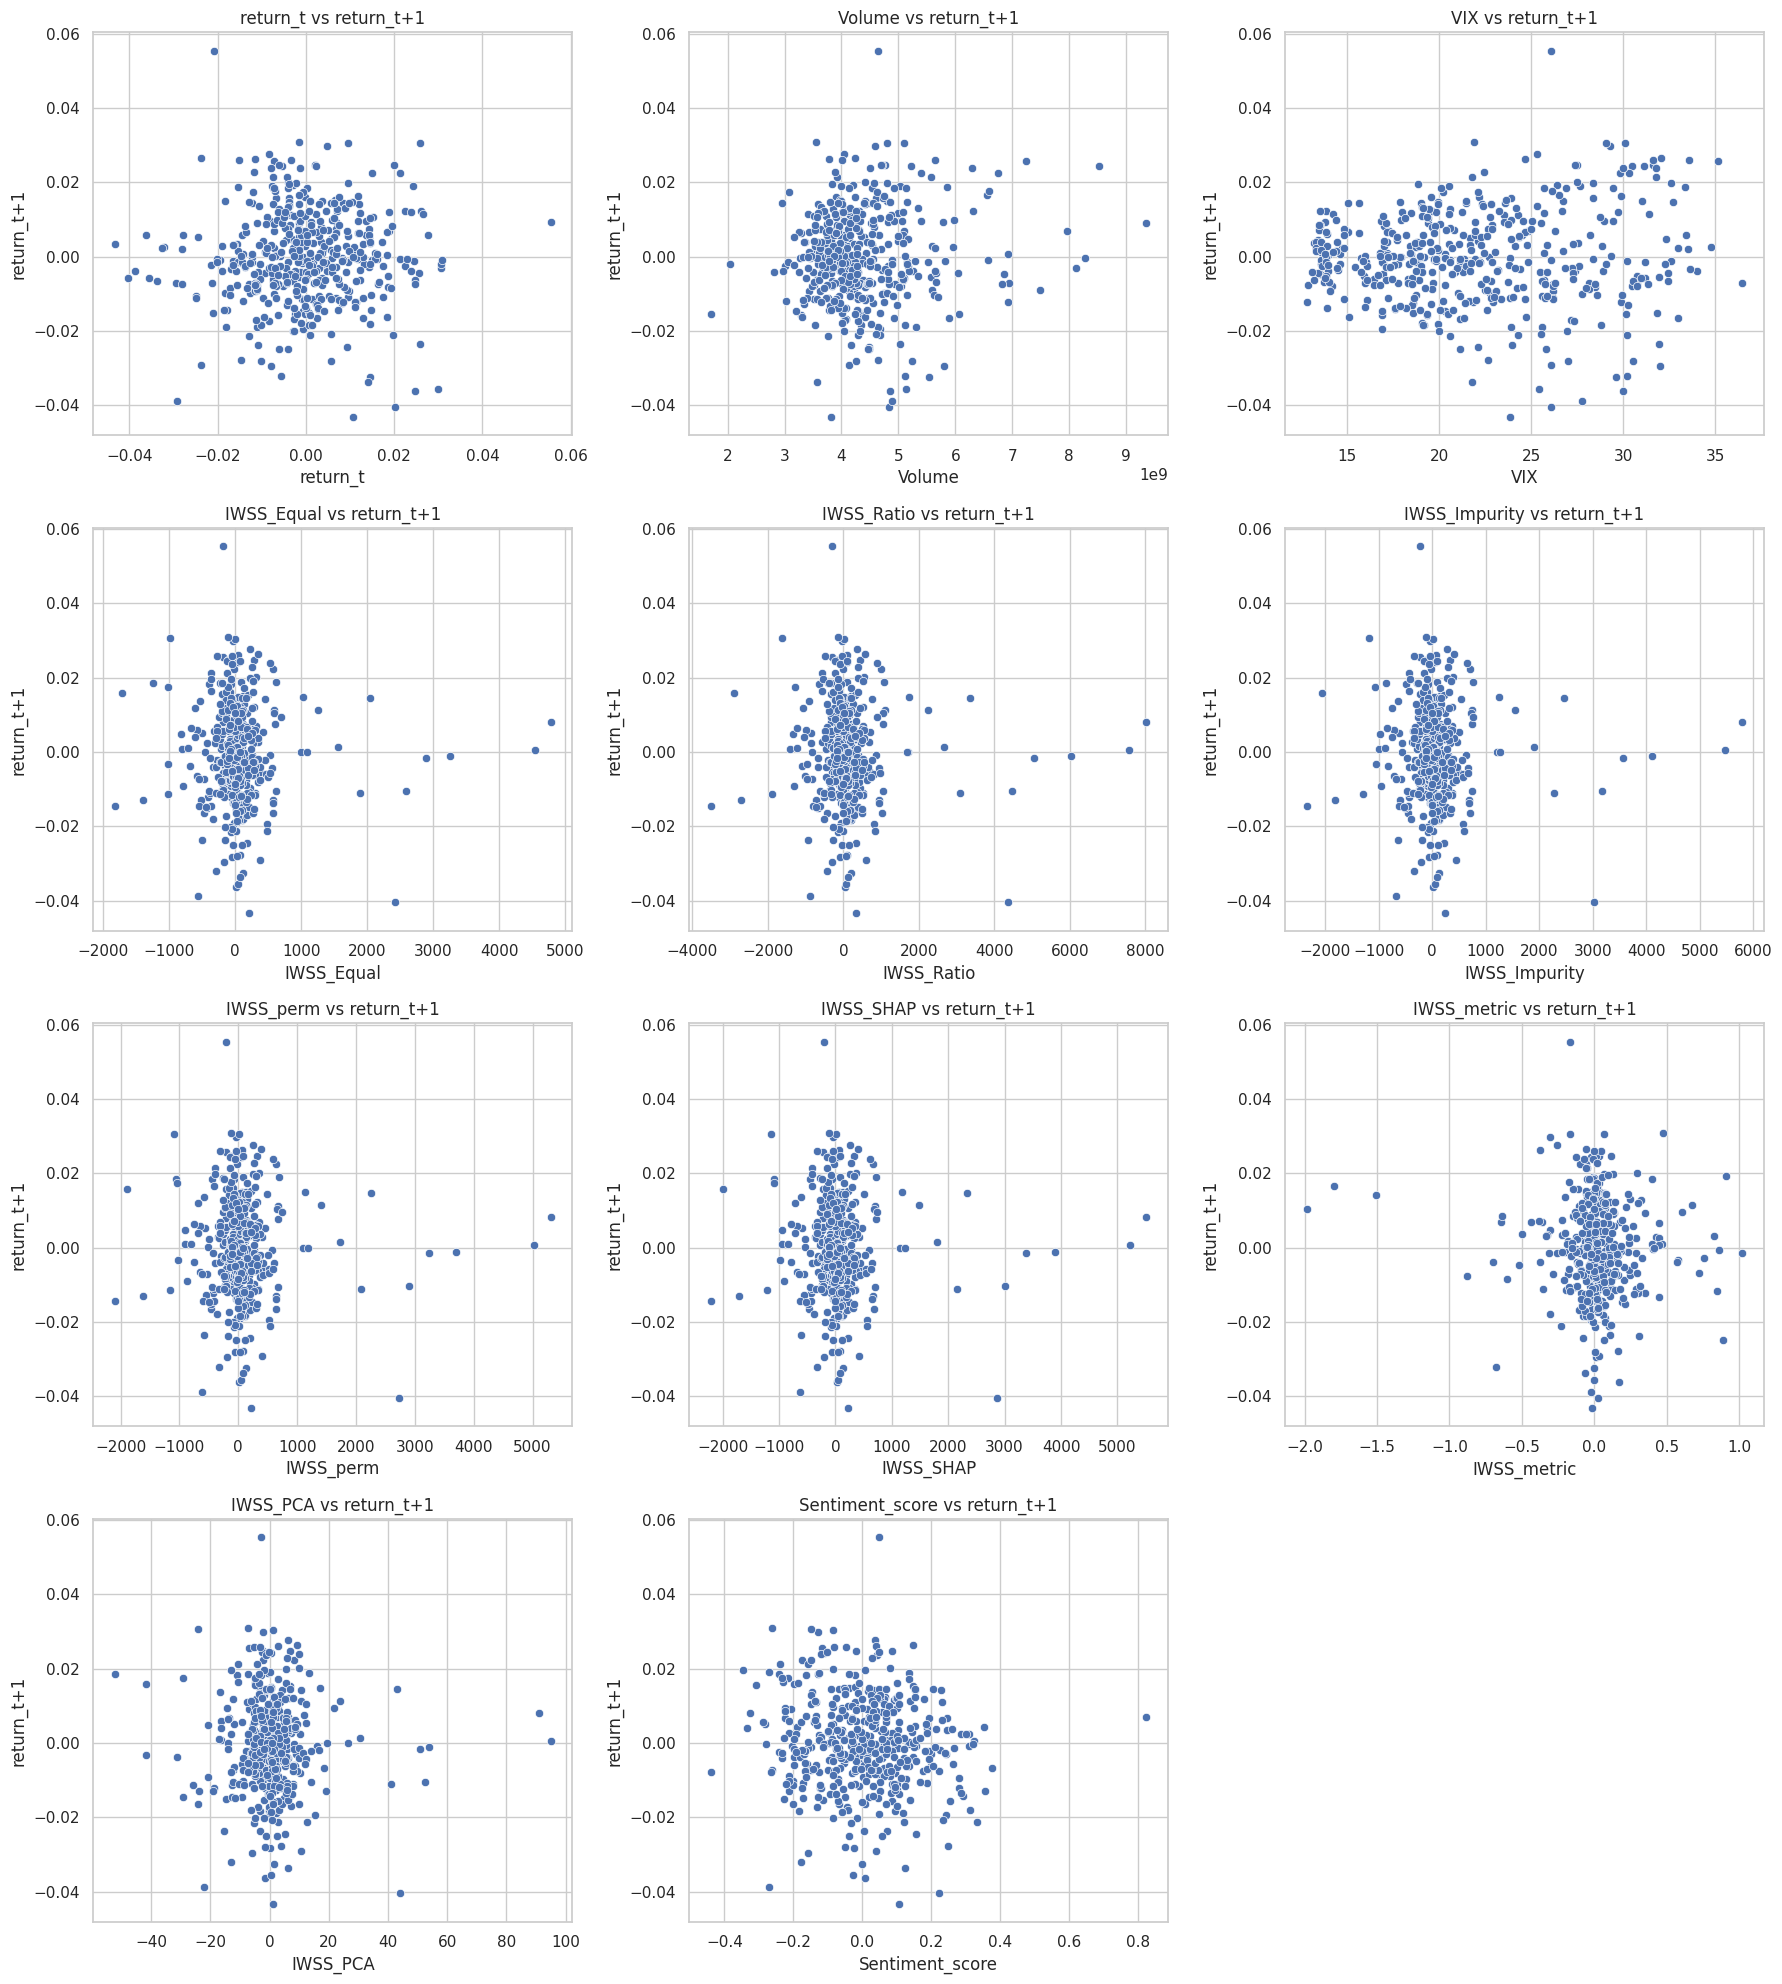

In [ ]:
n_cols = 3
n_rows = -(-len(all_features) // n_cols)
plt.figure(figsize=(18, 5 * n_rows))

for i, col in enumerate(all_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=df_train[col], y=df_train[target])
    plt.title(f'{col} vs {target}')

plt.tight_layout()
plt.show()

return does not have linear relationshi. also IWSS. Sentiment score has a slight positive trend, however, still very not linear. This suggest the linear models may not be very effective.

### Boxplots

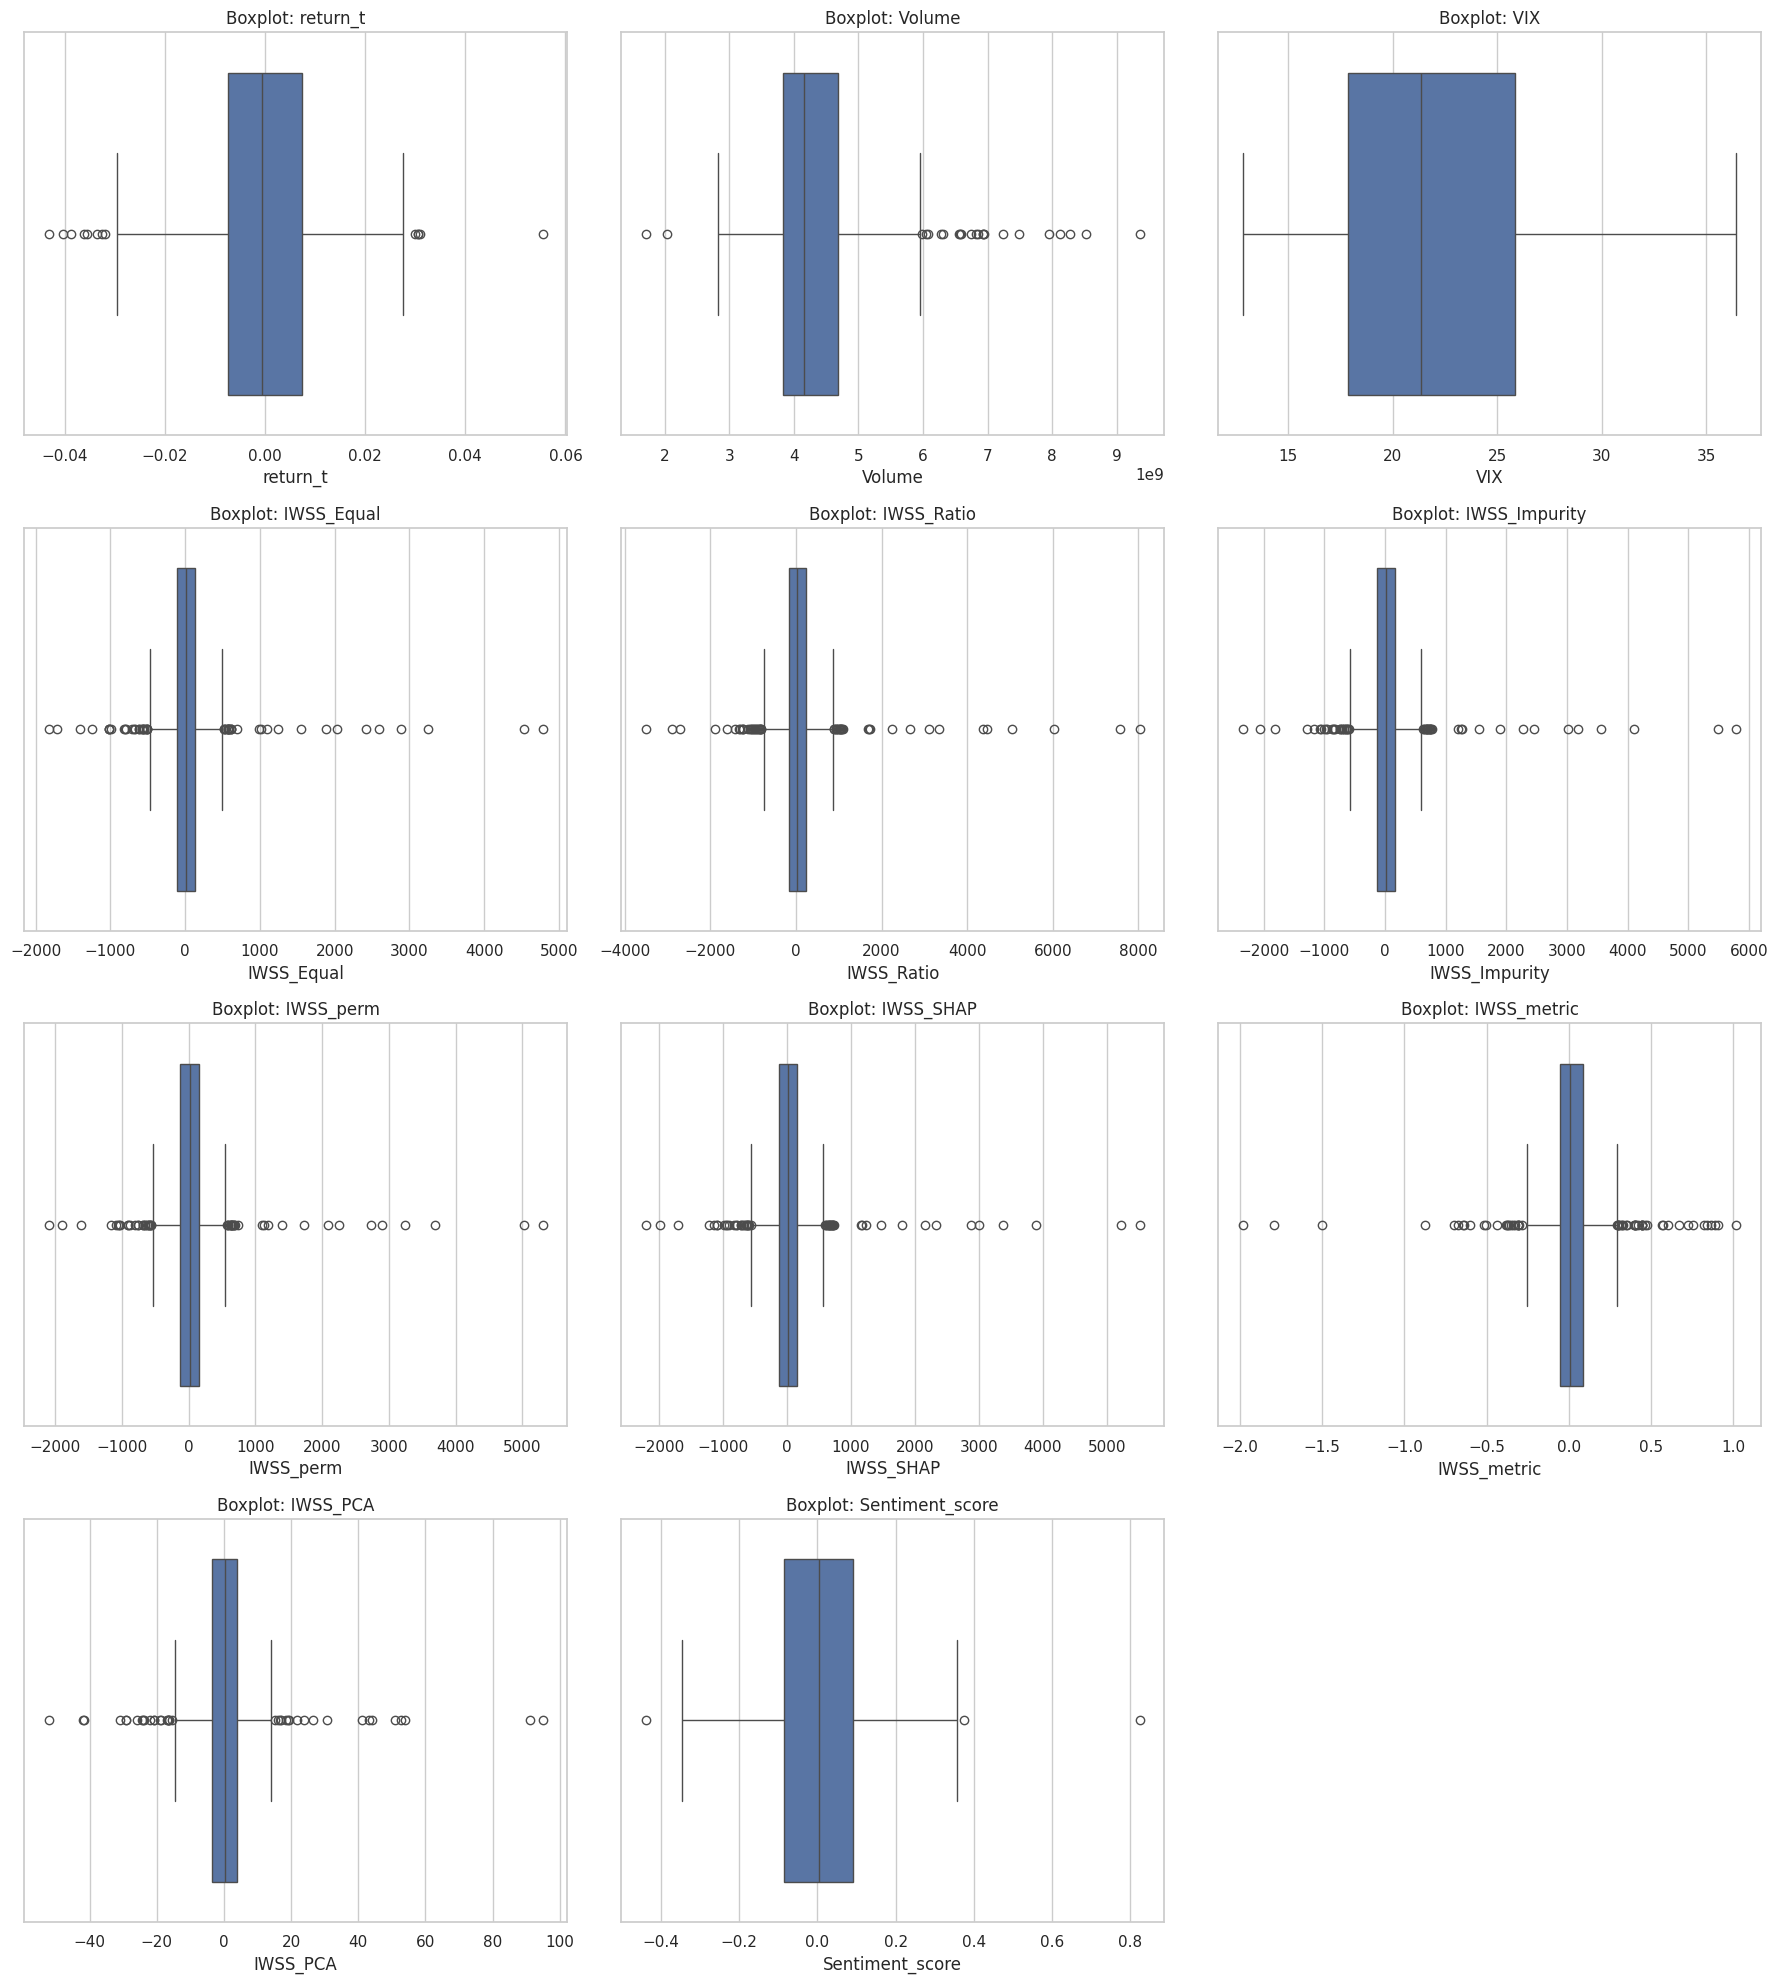

In [ ]:
plt.figure(figsize=(18, 5 * n_rows))
for i, col in enumerate(all_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df_train[col])
    plt.title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

IWSS has quite a few outliers.

### ACF (autocorrelation)

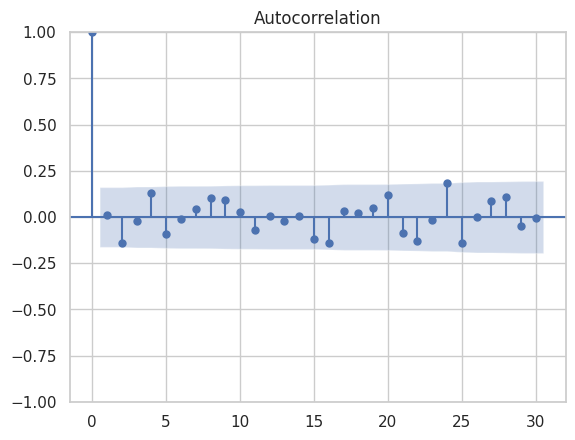

In [ ]:
# ACF
plot_acf(df_val[target].dropna(), lags=30)
plt.show()


No significant autocorrelation exists beyond lag 0. this suggsest that the time series is random and most likely not linearly predictable from the past values. Hence why we should test other models.

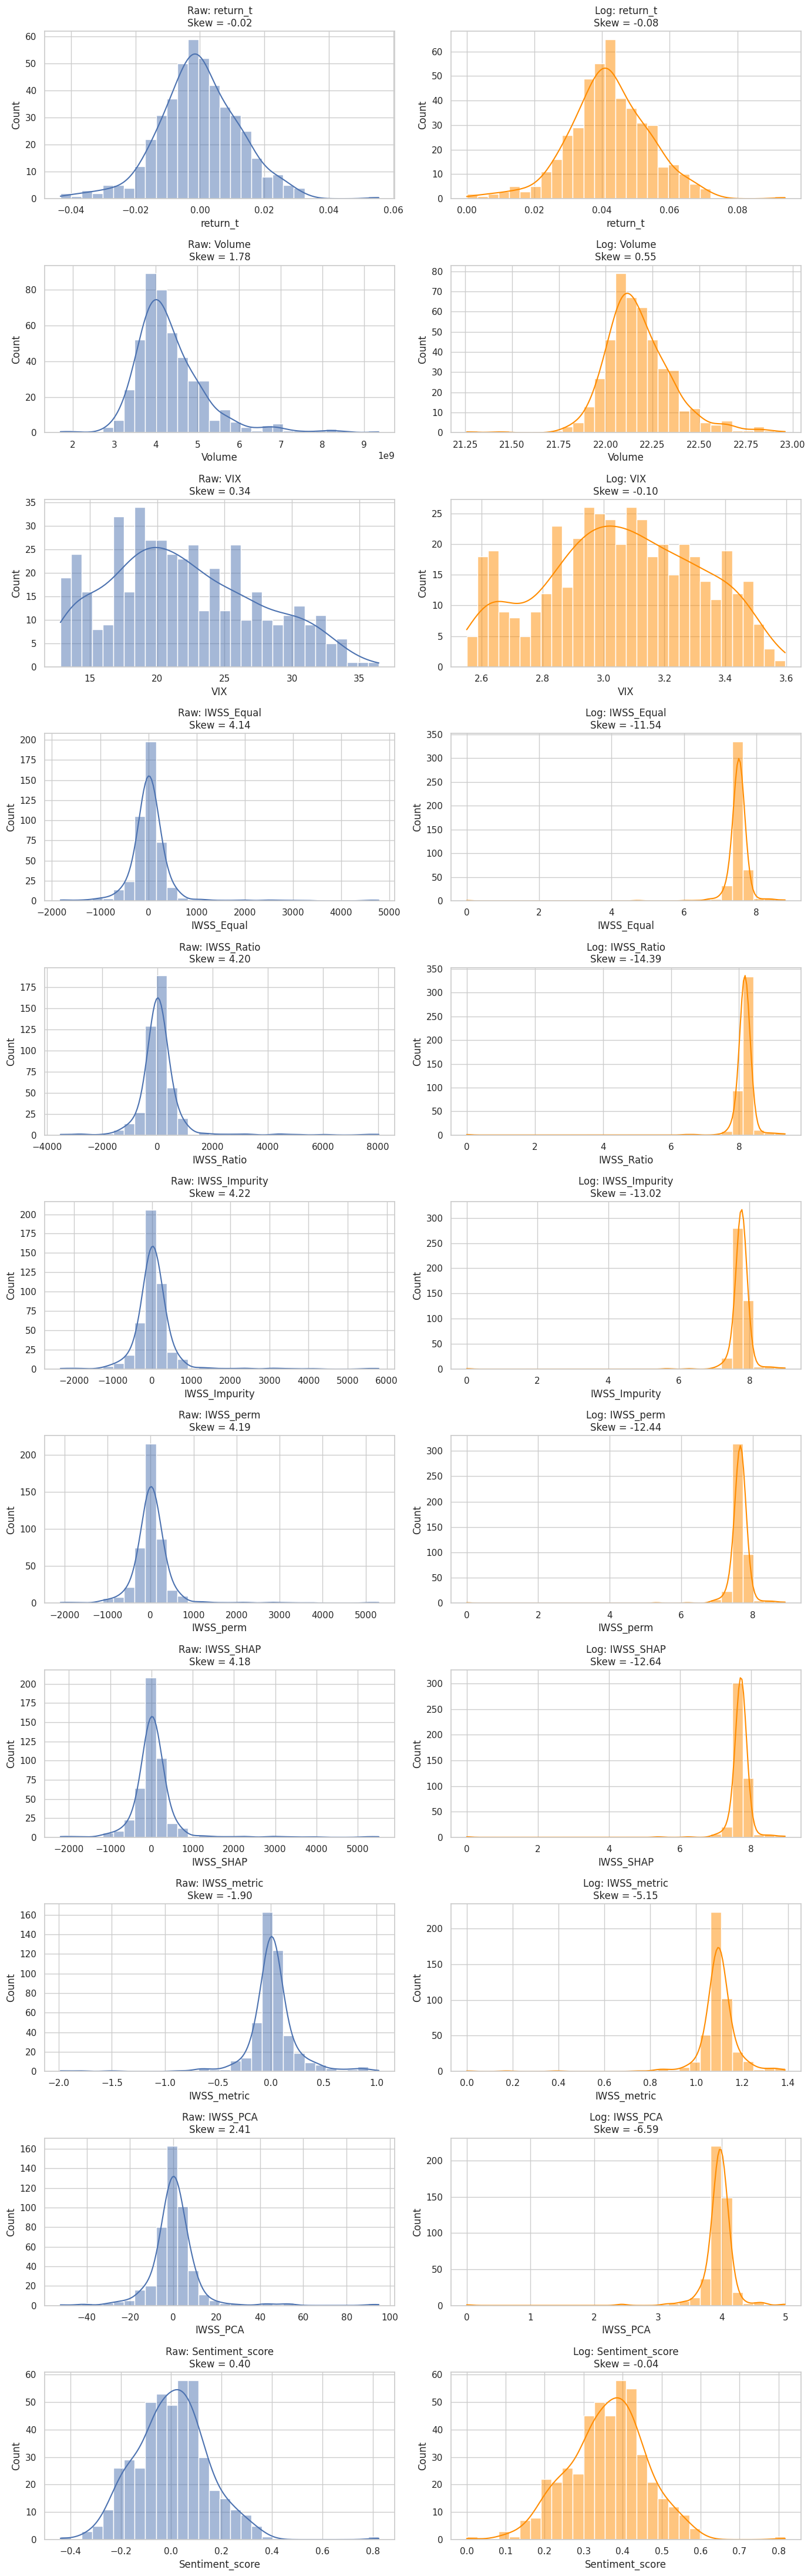

In [ ]:
n_cols = 2
n_rows = len(all_features)
plt.figure(figsize=(14, 4 * n_rows))

for i, col in enumerate(all_features):
    data = df_train[col].dropna()
    raw_skew = skew(data)

    plt.subplot(n_rows, n_cols, 2 * i + 1)
    sns.histplot(data, kde=True, bins=30)
    plt.title(f'Raw: {col}\nSkew = {raw_skew:.2f}')

    if (data <= 0).any():
        log_data = np.log1p(data - data.min() + 1e-6)
    else:
        log_data = np.log(data)

    log_skew = skew(log_data)
    plt.subplot(n_rows, n_cols, 2 * i + 2)
    sns.histplot(log_data, kde=True, bins=30, color='darkorange')
    plt.title(f'Log: {col}\nSkew = {log_skew:.2f}')

plt.tight_layout()
plt.show()


most raw features are skewed, especially IWSS variants which have quite a strong right skew. applying the log transformation does not really help. however, for volume and sentiment score it helps a little bit, but not by a lot.

### Scaling and comparison

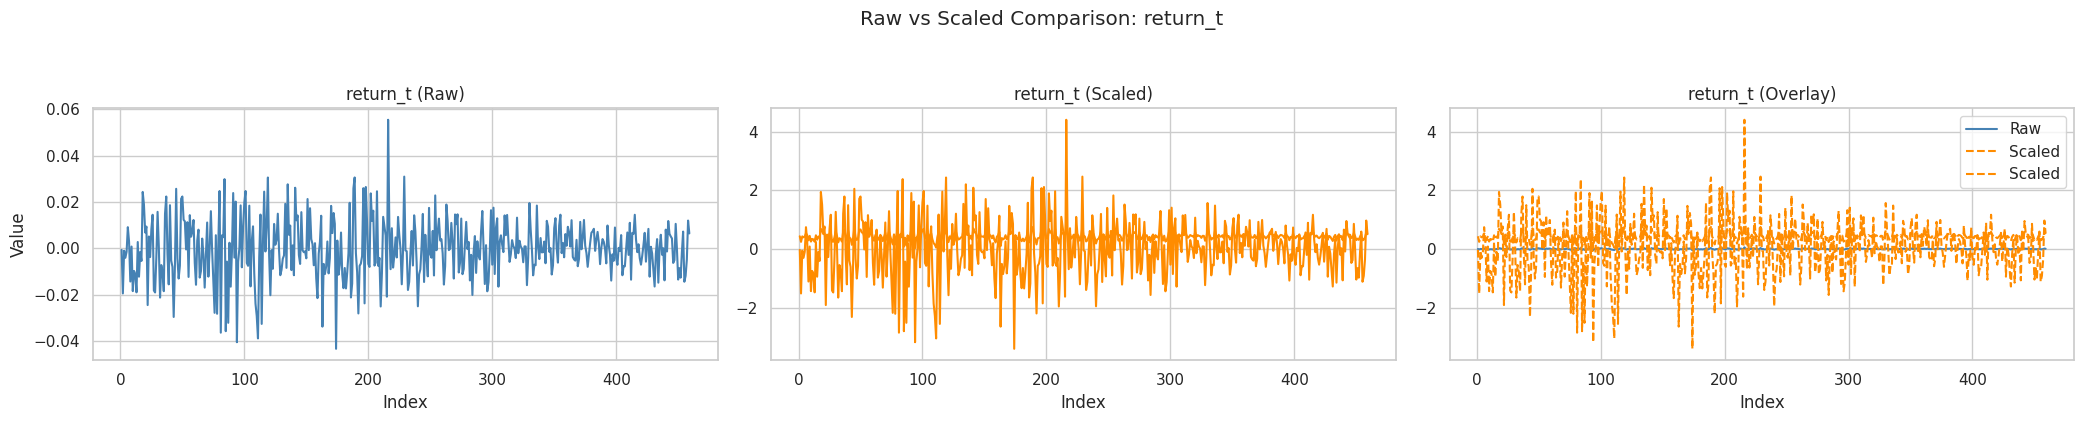

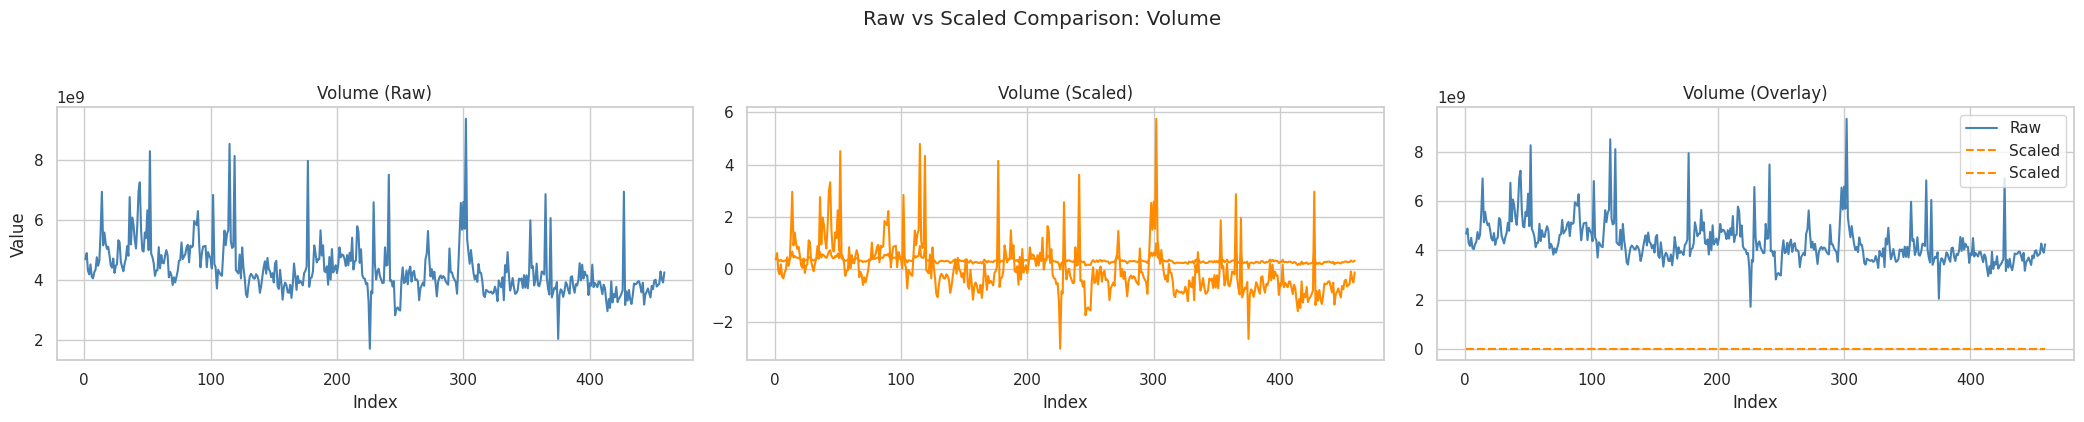

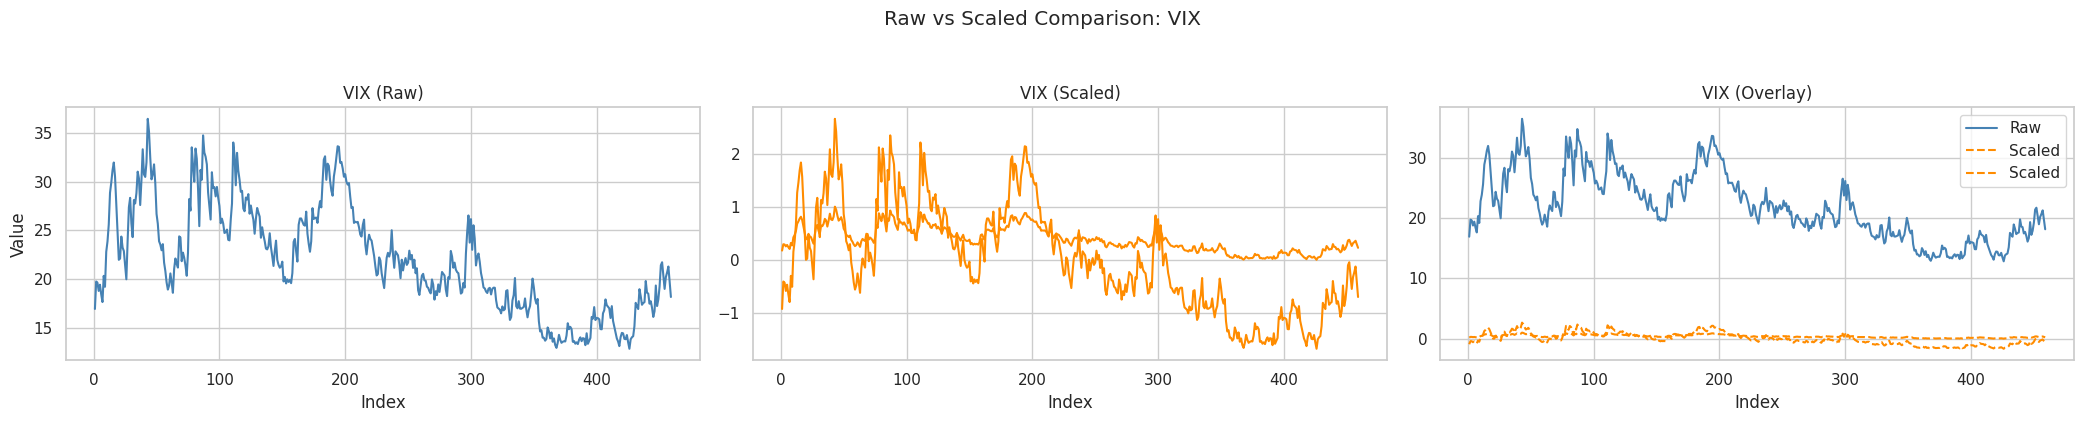

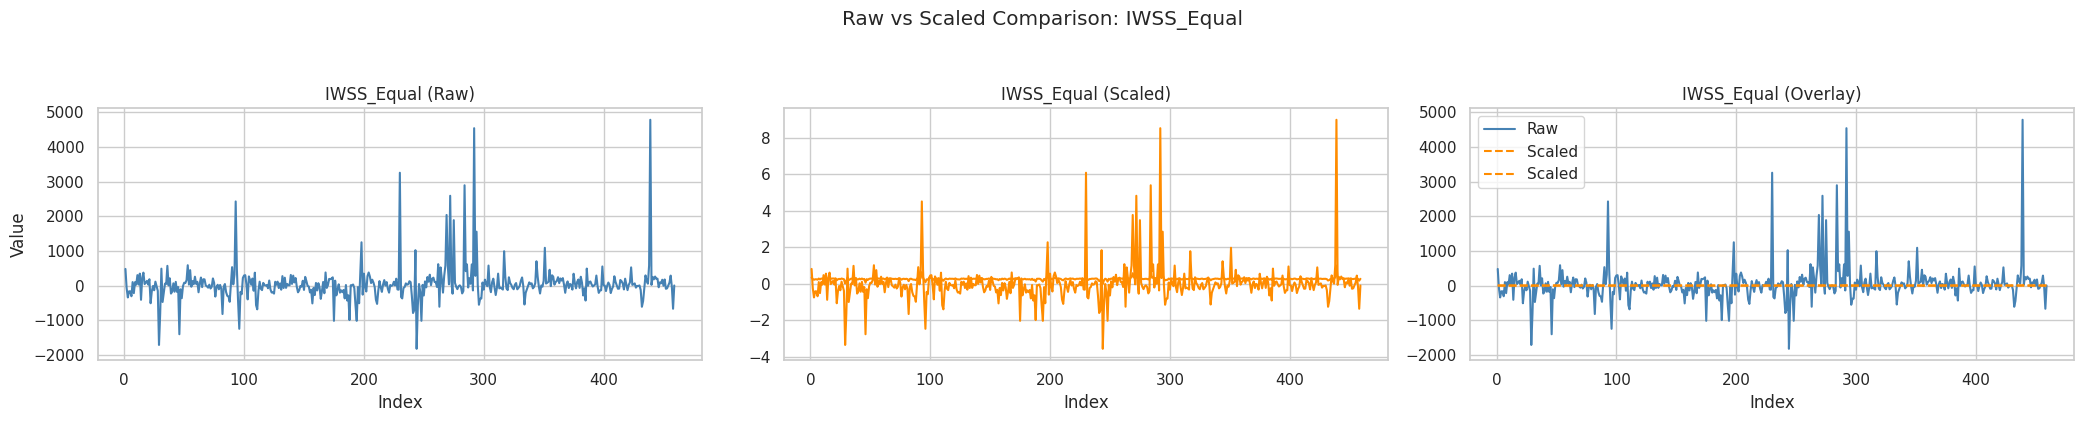

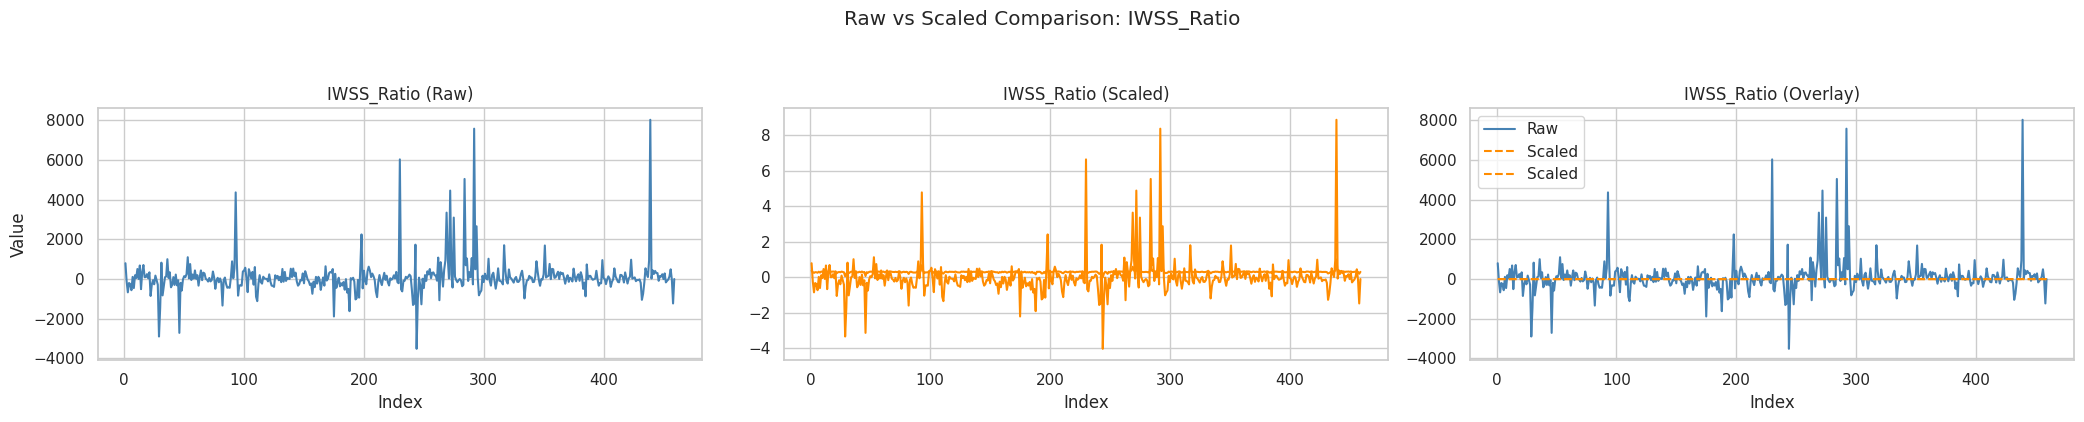

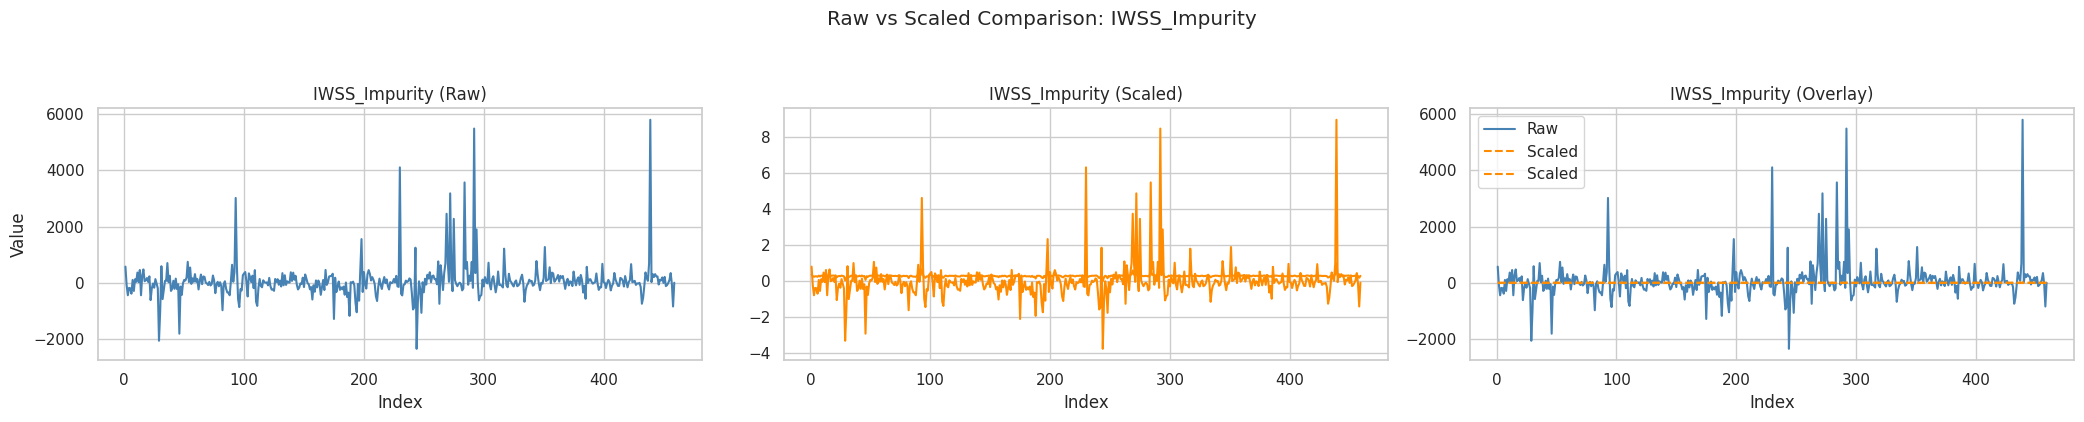

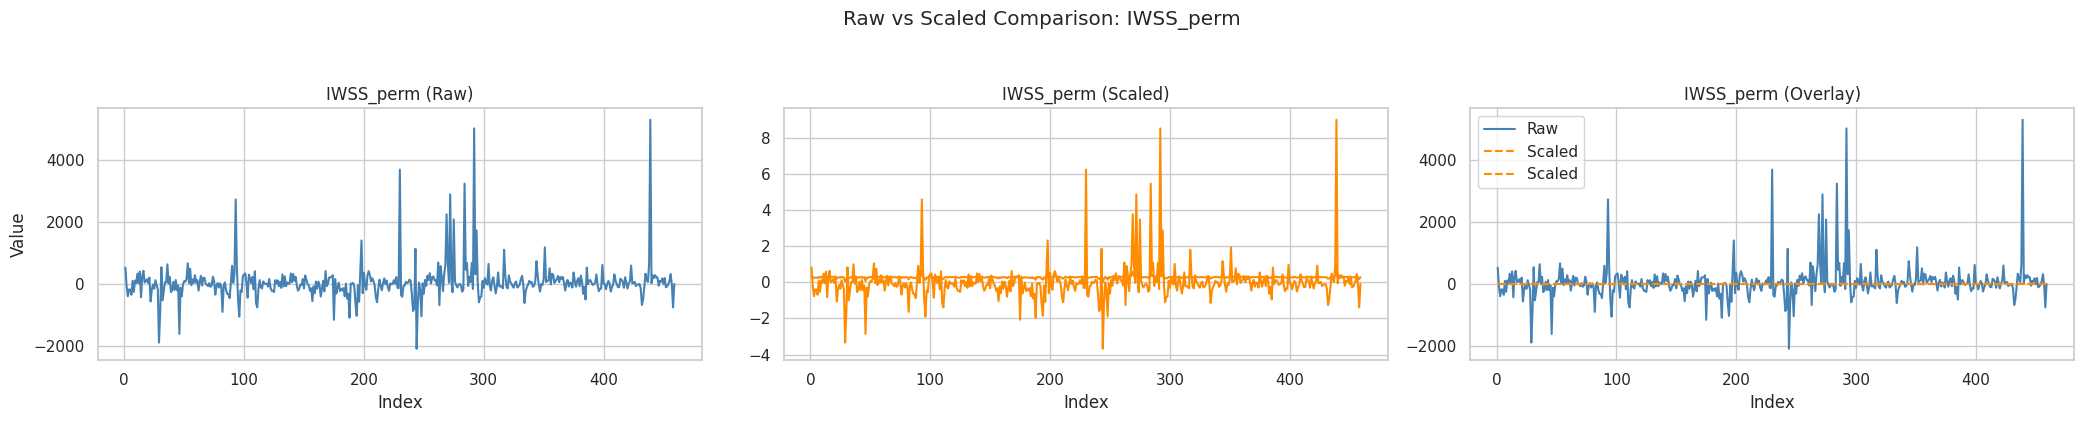

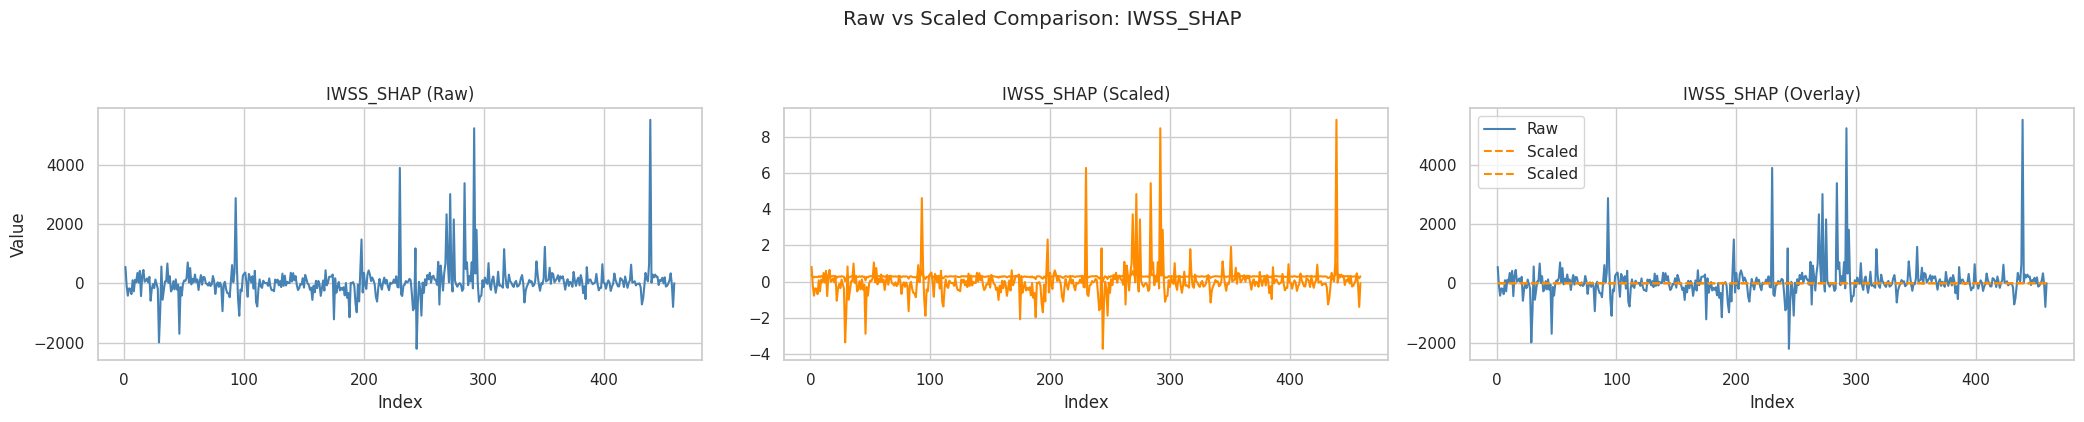

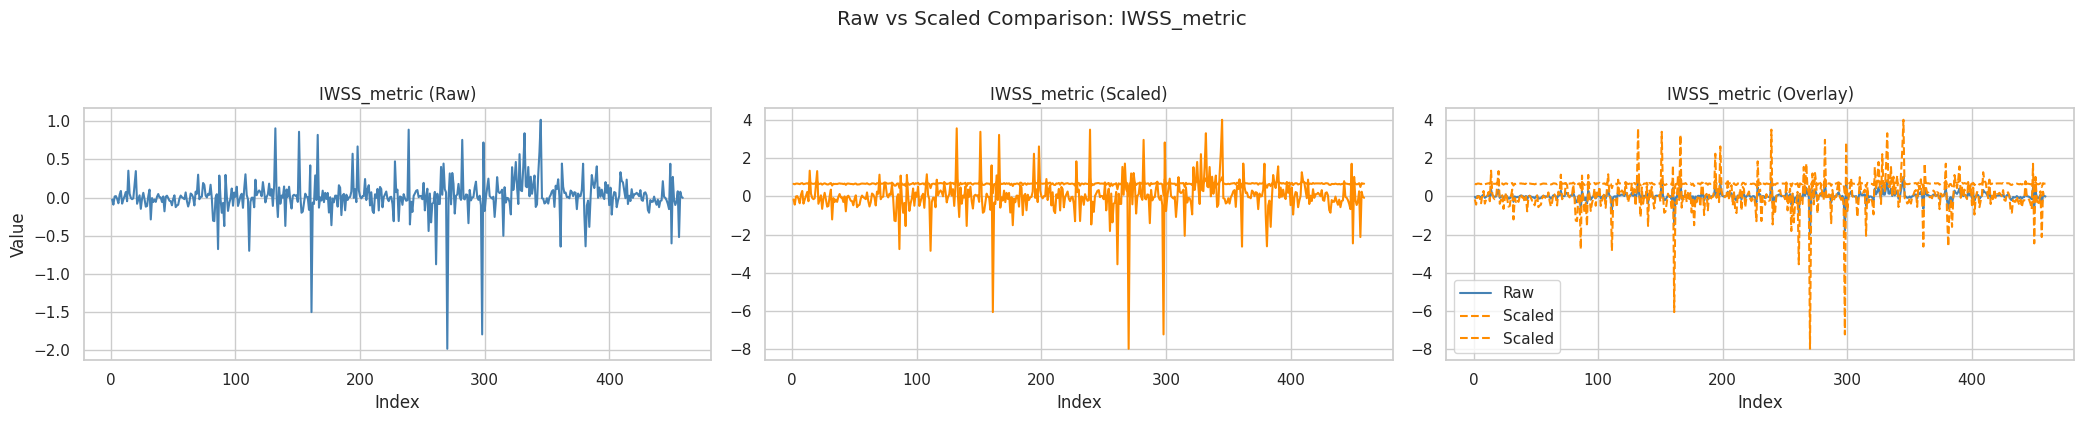

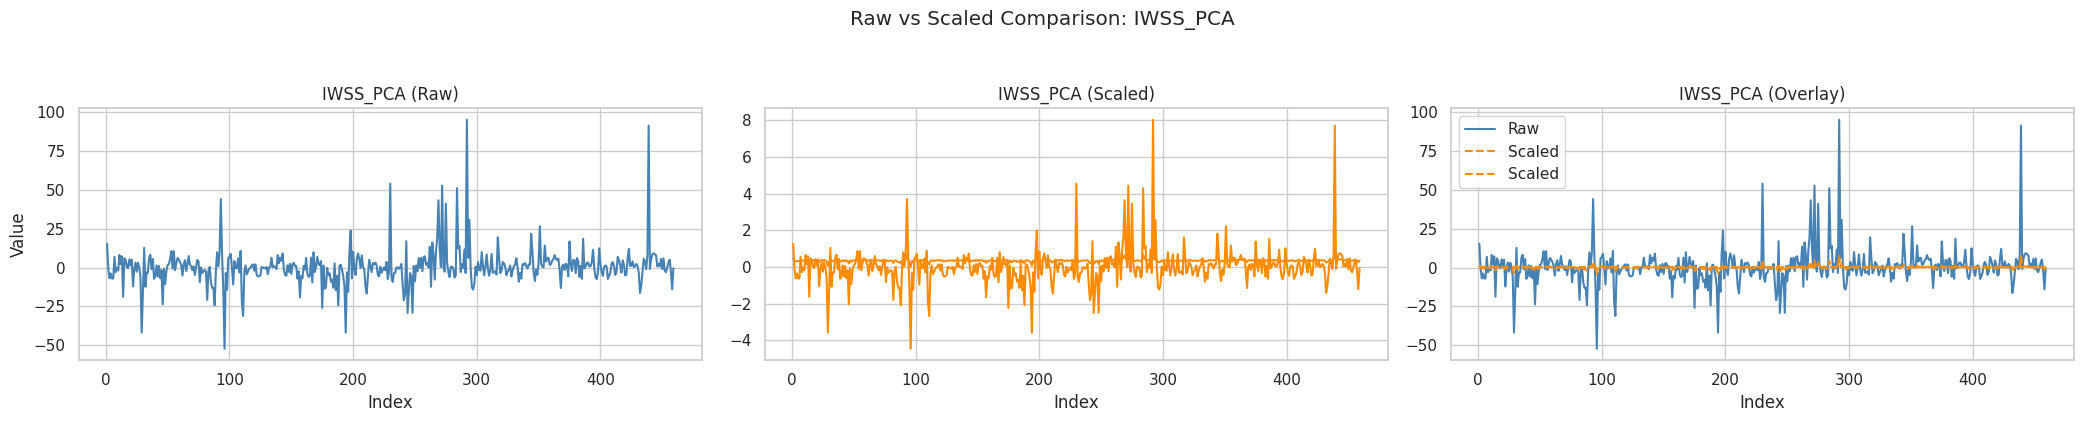

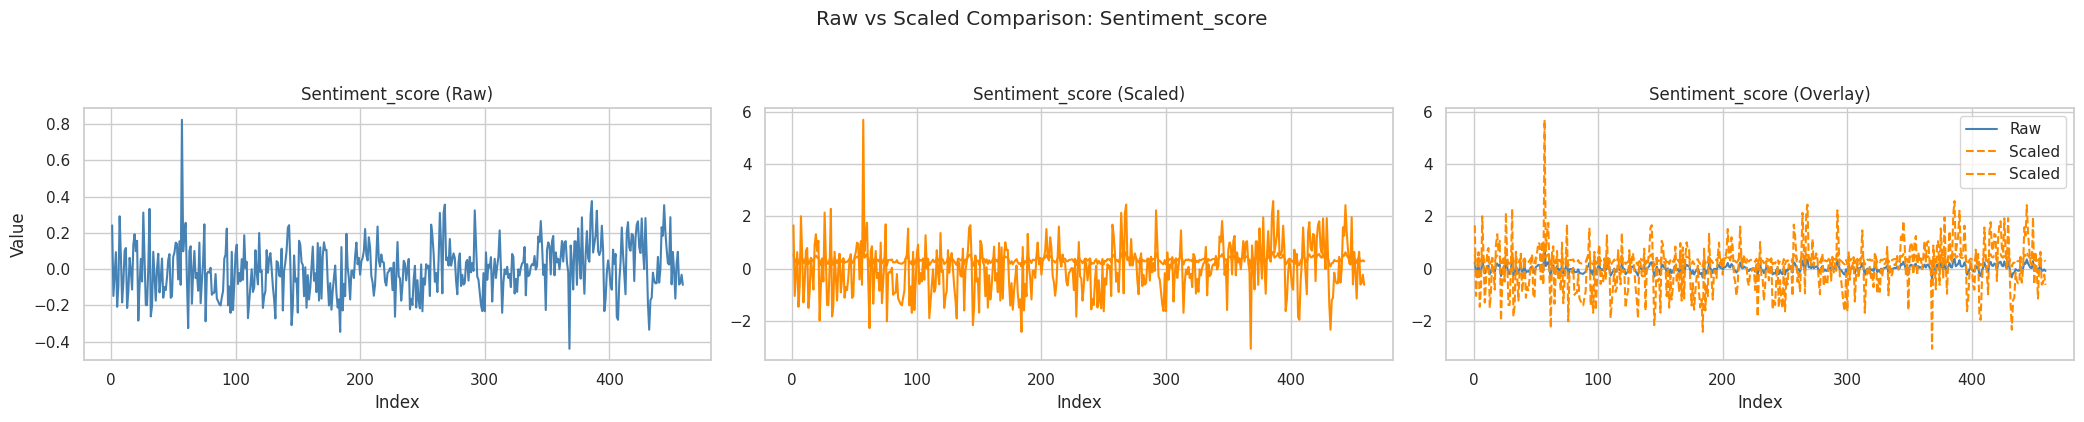

In [ ]:
# MinMax Scaling
variables = [target] + all_features
scaler = StandardScaler()
scaled = scaler.fit_transform(df_train[variables])
scaled_df = pd.DataFrame(scaled, columns=[f"{col}_scaled" for col in variables], index=df_train.index)
df_train = pd.concat([df_train, scaled_df], axis=1)

# Compare raw vs scaled and include overlay
for var in all_features:
    fig, axes = plt.subplots(1, 3, figsize=(21, 4), sharex=True)

    # Raw plot
    axes[0].plot(df_train.index, df_train[var], color='steelblue')
    axes[0].set_title(f'{var} (Raw)')
    axes[0].grid(True)
    axes[0].set_xlabel("Index")
    axes[0].set_ylabel("Value")

    # Scaled plot
    axes[1].plot(df_train.index, df_train[f'{var}_scaled'], color='darkorange')
    axes[1].set_title(f'{var} (Scaled)')
    axes[1].grid(True)
    axes[1].set_xlabel("Index")

    # Overlay plot
    axes[2].plot(df_train.index, df_train[var], label='Raw', color='steelblue')
    axes[2].plot(df_train.index, df_train[f'{var}_scaled'], label='Scaled', linestyle='--', color='darkorange')
    axes[2].set_title(f'{var} (Overlay)')
    axes[2].legend()
    axes[2].grid(True)
    axes[2].set_xlabel("Index")

    plt.suptitle(f'Raw vs Scaled Comparison: {var}', y=1.05)
    plt.tight_layout()
    plt.show()

In [ ]:
# Rolling correlations
rolling_windows = [5, 10, 30]

for col in all_features:
    plt.figure(figsize=(14, 4))
    for w in rolling_windows:
        roll_corr = df_train[target].rolling(window=w).corr(df_train[col])
        plt.plot(df_train.index, roll_corr, label=f"{w}-day")
    plt.title(f"Rolling Correlation: {target} vs {col}")
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

## OLS Assumptions

In [4]:
# --- OLS Assumptions Diagnostic Function ---
def check_ols_assumptions(X_scaled, y_true, y_pred, residuals, feature_names, label=None):
  model_name = f"Model: {label}" if label else "Model"
  print(f"\n{'='*60}\nChecking OLS Assumptions — {model_name}\n{'='*60}")

  conclusions = {}

  # Linearity Assumptions
  print("\n[1] Linearity (Residuals vs. Predicted)")
  plt.figure(figsize=(6, 4))
  plt.scatter(y_pred, residuals, alpha=0.7)
  plt.axhline(0, color='red', linestyle='--')
  plt.xlabel("Predicted Values")
  plt.ylabel("Residuals")
  plt.title(f"{model_name} — Residuals vs. Predicted")
  plt.tight_layout()
  plt.show()
  conclusions['Linearity'] = "Check residuals plot visually. Look for random scatter."

  # Multicollinearity - VIF
  print("\n[2] Multicollinearity (VIF)")
  X_df = pd.DataFrame(X_scaled, columns=feature_names)
  vif_data = pd.DataFrame()
  vif_data["Feature"] = feature_names
  vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
  print(vif_data)

  high_vif = vif_data[vif_data["VIF"] > 3]
  if not high_vif.empty:
    conclusions['Multicollinearity'] = f"⚠️ Problem: {len(high_vif)} feature(s) with VIF > 3"
  else:
    conclusions['Multicollinearity'] = "✅ No multicollinearity concern (all VIF ≤ 3)"

 # Homoscedasticity - Breusch-Pagan Test
  print("\n[3] Homoscedasticity (Breusch-Pagan Test)")
  X_sm = sm.add_constant(X_scaled)
  bp_test = het_breuschpagan(residuals, X_sm)
  bp_p = bp_test[1]
  labels = ['Lagrange Multiplier stat', 'p-value', 'f-value', 'f p-value']
  print(dict(zip(labels, bp_test)))
  conclusions['Homoscedasticity'] = (
      f"{'✅' if bp_p > 0.05 else '⚠️ Problem:'} "
      f"p-value = {bp_p:.4f} ({'no' if bp_p > 0.05 else 'potential'} heteroscedasticity)"
  )

  # Autocorrelation assumptions - Durbin-Watson
  print("\n[4] Autocorrelation (Durbin-Watson)")
  dw_stat = durbin_watson(residuals)
  print(f"Durbin-Watson Statistic: {dw_stat:.3f} (ideal ~2.0)")
  if dw_stat < 1.5 or dw_stat > 2.5:
      conclusions['Autocorrelation'] = f"⚠️ Problem: DW = {dw_stat:.3f} (likely autocorrelation)"
  else:
      conclusions['Autocorrelation'] = f"✅ DW = {dw_stat:.3f} (no autocorrelation)"

  # Normality of Residuals
  print("\n[5] Normality of Residuals")
  plt.figure(figsize=(6, 4))
  sns.histplot(residuals, kde=True)
  plt.title(f"{model_name} — Histogram of Residuals")
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(6, 4))
  probplot(residuals, dist="norm", plot=plt)
  plt.title(f"{model_name} — Q-Q Plot")
  plt.tight_layout()
  plt.show()

  shapiro_stat, shapiro_p = shapiro(residuals)
  print(f"Shapiro-Wilk Test p-value: {shapiro_p:.4f} (p > 0.05 suggests normality)")
  conclusions['Normality'] = (
      f"{'✅' if shapiro_p > 0.05 else '⚠️ Problem:'} "
      f"p-value = {shapiro_p:.4f} ({'normal' if shapiro_p > 0.05 else 'non-normal'} residuals)"
  )

  # Summary
  print(f"\n{'-'*50}\nConclusion Summary — {model_name}\n{'-'*50}")
  for k, v in conclusions.items():
      print(f"{k}: {v}")



## OLS Regression

In [5]:
from sklearn.inspection import permutation_importance

In [16]:
def evaluate_linear_model(name, X_train, y_train, X_test, y_test, run_diagnostics=False):
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Forecast errors
    errors = y_test - y_test_pred


    # Test Metrics
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)
    denom = np.sum(y_test**2)
    roos = 1 - np.sum((y_test - y_test_pred)**2) / denom
    test_correct = ((np.sign(y_test_pred) == np.sign(y_test))).sum()
    test_accuracy = test_correct / len(y_test)

    # Train Metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, y_train_pred)
    train_correct = ((np.sign(y_train_pred) == np.sign(y_train))).sum()
    train_accuracy = train_correct / len(y_train)

    coef_dict = dict(zip(X_train.columns, model.coef_))

    # Calculate permutation importance
    result = permutation_importance(
        model,
        X_train_scaled,
        y_train,
        n_repeats=30,
        random_state=42,
        scoring='neg_mean_squared_error'
    )
    perm_scores = pd.Series(result.importances_mean, index=X_train.columns)
    perm_importance_dict[name] = perm_scores

    results.append({
        'Model': name,
        'Train R²': train_r2,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Train RMSE': train_rmse,
        'Train Directional Accuracy (%)': train_accuracy * 100,
        'Train Correct': train_correct,
        'Train Total': len(y_train),
        'Test R²': test_r2,
        'ROOS': roos,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Test RMSE': test_rmse,
        'Test Directional Accuracy (%)': test_accuracy * 100,
        'Test Correct': test_correct,
        'Test Total': len(y_test)
    })
    # Optional: Check OLS Assumptions
    if run_diagnostics:
        residuals = y_test - y_train_pred
        check_ols_assumptions(
            X_test_scaled,
            y_test,
            y_pred,
            residuals,
            feature_names=X_test.columns.tolist(),
            label=name
        )

    return model, y_test_pred, errors, coef_dict

In [8]:
df_test.isna().sum()

trading_day        0
IWSS_Equal         0
IWSS_Ratio         0
IWSS_Impurity      0
IWSS_perm          0
IWSS_SHAP          0
IWSS_metric        0
IWSS_PCA           0
Sentiment_score    0
Date               0
Close              0
High               0
Low                0
Open               0
Volume             0
VIX                0
return_t           0
return_t+1         1
dtype: int64

In [9]:
df_test = df_test.dropna(subset=['return_t+1'])

In [17]:
results = []
errors_dict = {}
models = {}
coefs_dict = {}
perm_importance_dict  = {}


y_train = df_train[target]
y_test = df_test[target]

# ----- Base Model ------
model, _, errors, coef_dict  = evaluate_linear_model(
    'Base',
    df_train[base_features],
    y_train,
    df_test[base_features],
    y_test,
    run_diagnostics=False
)
errors_dict['Base'] = errors
models['Base'] = model
coefs_dict['Base'] = coef_dict


# Sentiment model
model, _, errors, coef_dict  = evaluate_linear_model(
    'Base + Sentiment_score',
    df_train[base_features + ['Sentiment_score']],
    y_train,
    df_test[base_features + ['Sentiment_score']],
    y_test,
    run_diagnostics=False
)
errors_dict['Sentiment_score'] = errors
models['Sentiment_score'] = model
coefs_dict['Sentiment_score'] = coef_dict

# Save for comparison
sentiment_errors = errors

# IWSS models
for feat in sentiment_features:
    if feat == 'Sentiment_score':
        continue

    name = f'Base + {feat}'
    model, _, errors, coef_dict  = evaluate_linear_model(
        name,
        df_train[base_features + [feat]],
        y_train,
        df_test[base_features + [feat]],
        y_test,
        run_diagnostics=False
    )
    errors_dict[feat] = errors
    models[feat] = model
    coefs_dict[feat] = coef_dict


In [15]:
results_OLS = pd.DataFrame(results)
results_OLS

Model  Train R²  Train MSE  Train MAE  Train RMSE  \
0                    Base  0.004427   0.000159   0.009625    0.012598   
1  Base + Sentiment_score  0.017101   0.000157   0.009566    0.012517   
2       Base + IWSS_Equal  0.004763   0.000159   0.009628    0.012596   
3       Base + IWSS_Ratio  0.004618   0.000159   0.009626    0.012596   
4    Base + IWSS_Impurity  0.004667   0.000159   0.009626    0.012596   
5        Base + IWSS_perm  0.004709   0.000159   0.009627    0.012596   
6        Base + IWSS_SHAP  0.004730   0.000159   0.009627    0.012596   
7      Base + IWSS_metric  0.008457   0.000158   0.009591    0.012572   
8         Base + IWSS_PCA  0.004617   0.000159   0.009624    0.012596   

   Train Directional Accuracy (%)  Train Correct  Train Total   Test R²  \
0                       50.762527            233          459 -0.035922   
1                       54.901961            252          459 -0.139929   
2                       50.544662            232          459 -0.026776   
3                       50.544662            232          459 -0.028458   
4                       50.544662            232          459 -0.027968   
5                       50.544662            232          459 -0.027393   
6                       50.544662            232          459 -0.026939   
7                       54.030501            248          459 -0.107717   
8                       50.544662            232          459 -0.032321   

       ROOS  Test MSE  Test MAE  Test RMSE  Test Directional Accuracy (%)  \
0 -0.027419  0.000075  0.006369   0.008657                      45.578231   
1 -0.130571  0.000082  0.006936   0.009082                      42.176871   
2 -0.018347  0.000074  0.006350   0.008619                      46.258503   
3 -0.020015  0.000074  0.006354   0.008626                      46.258503   
4 -0.019530  0.000074  0.006352   0.008624                      46.258503   
5 -0.018959  0.000074  0.006351   0.008622                      46.258503   
6 -0.018509  0.000074  0.006350   0.008620                      46.258503   
7 -0.098624  0.000080  0.006726   0.008952                      46.258503   
8 -0.023846  0.000075  0.006362   0.008642                      46.258503   

   Test Correct  Test Total  
0            67         147  
1            62         147  
2            68         147  
3            68         147  
4            68         147  
5            68         147  
6            68         147  
7            68         147  
8            68         147

In [ ]:
coefs_df = pd.DataFrame(coefs_dict).T  # models as rows
display(coefs_df.round(6))

return_t    Volume       VIX  Sentiment_score  IWSS_Equal  \
Base             0.000230  0.000581  0.000355              NaN         NaN   
Sentiment_score  0.000684  0.000611 -0.000106        -0.001579         NaN   
IWSS_Equal       0.000246  0.000586  0.000320              NaN   -0.000235   
IWSS_Ratio       0.000241  0.000585  0.000332              NaN         NaN   
IWSS_Impurity    0.000243  0.000585  0.000327              NaN         NaN   
IWSS_perm        0.000245  0.000585  0.000324              NaN         NaN   
IWSS_SHAP        0.000245  0.000586  0.000323              NaN         NaN   
IWSS_metric      0.000310  0.000513  0.000333              NaN         NaN   
IWSS_PCA         0.000250  0.000582  0.000316              NaN         NaN   

                 IWSS_Ratio  IWSS_Impurity  IWSS_perm  IWSS_SHAP  IWSS_metric  \
Base                    NaN            NaN        NaN        NaN          NaN   
Sentiment_score         NaN            NaN        NaN        NaN          NaN   
IWSS_Equal              NaN            NaN        NaN        NaN          NaN   
IWSS_Ratio        -0.000176            NaN        NaN        NaN          NaN   
IWSS_Impurity           NaN      -0.000198        NaN        NaN          NaN   
IWSS_perm               NaN            NaN  -0.000215        NaN          NaN   
IWSS_SHAP               NaN            NaN        NaN  -0.000223          NaN   
IWSS_metric             NaN            NaN        NaN        NaN     -0.00081   
IWSS_PCA                NaN            NaN        NaN        NaN          NaN   

                 IWSS_PCA  
Base                  NaN  
Sentiment_score       NaN  
IWSS_Equal            NaN  
IWSS_Ratio            NaN  
IWSS_Impurity         NaN  
IWSS_perm             NaN  
IWSS_SHAP             NaN  
IWSS_metric           NaN  
IWSS_PCA         -0.00018

In [ ]:
perm_df = pd.DataFrame(perm_importance_dict).T  # Models as rows

In [ ]:
perm_df

IWSS_Equal  IWSS_Impurity      IWSS_PCA  \
Base                             NaN            NaN           NaN   
Base + Sentiment_score           NaN            NaN           NaN   
Base + IWSS_Equal       1.611659e-07            NaN           NaN   
Base + IWSS_Ratio                NaN            NaN           NaN   
Base + IWSS_Impurity             NaN   1.216496e-07           NaN   
Base + IWSS_perm                 NaN            NaN           NaN   
Base + IWSS_SHAP                 NaN            NaN           NaN   
Base + IWSS_metric               NaN            NaN           NaN   
Base + IWSS_PCA                  NaN            NaN  9.641028e-08   

                          IWSS_Ratio     IWSS_SHAP  IWSS_metric     IWSS_perm  \
Base                             NaN           NaN          NaN           NaN   
Base + Sentiment_score           NaN           NaN          NaN           NaN   
Base + IWSS_Equal                NaN           NaN          NaN           NaN   
Base + IWSS_Ratio       1.004184e-07           NaN          NaN           NaN   
Base + IWSS_Impurity             NaN           NaN          NaN           NaN   
Base + IWSS_perm                 NaN           NaN          NaN  1.392118e-07   
Base + IWSS_SHAP                 NaN  1.474636e-07          NaN           NaN   
Base + IWSS_metric               NaN           NaN     0.000001           NaN   
Base + IWSS_PCA                  NaN           NaN          NaN           NaN   

                        Sentiment_score           VIX        Volume  \
Base                                NaN  3.282779e-07  8.406082e-07   
Base + Sentiment_score         0.000005 -2.497354e-09  9.136416e-07   
Base + IWSS_Equal                   NaN  2.733938e-07  8.544645e-07   
Base + IWSS_Ratio                   NaN  2.920240e-07  8.517081e-07   
Base + IWSS_Impurity                NaN  2.842425e-07  8.526885e-07   
Base + IWSS_perm                    NaN  2.793806e-07  8.535383e-07   
Base + IWSS_SHAP                    NaN  2.782048e-07  8.540452e-07   
Base + IWSS_metric                  NaN  2.912838e-07  6.621544e-07   
Base + IWSS_PCA                     NaN  2.675238e-07  8.432137e-07   

                            return_t  
Base                    8.431491e-08  
Base + Sentiment_score  8.547306e-07  
Base + IWSS_Equal       9.775732e-08  
Base + IWSS_Ratio       9.342951e-08  
Base + IWSS_Impurity    9.520531e-08  
Base + IWSS_perm        9.635183e-08  
Base + IWSS_SHAP        9.666417e-08  
Base + IWSS_metric      1.611448e-07  
Base + IWSS_PCA         1.017292e-07

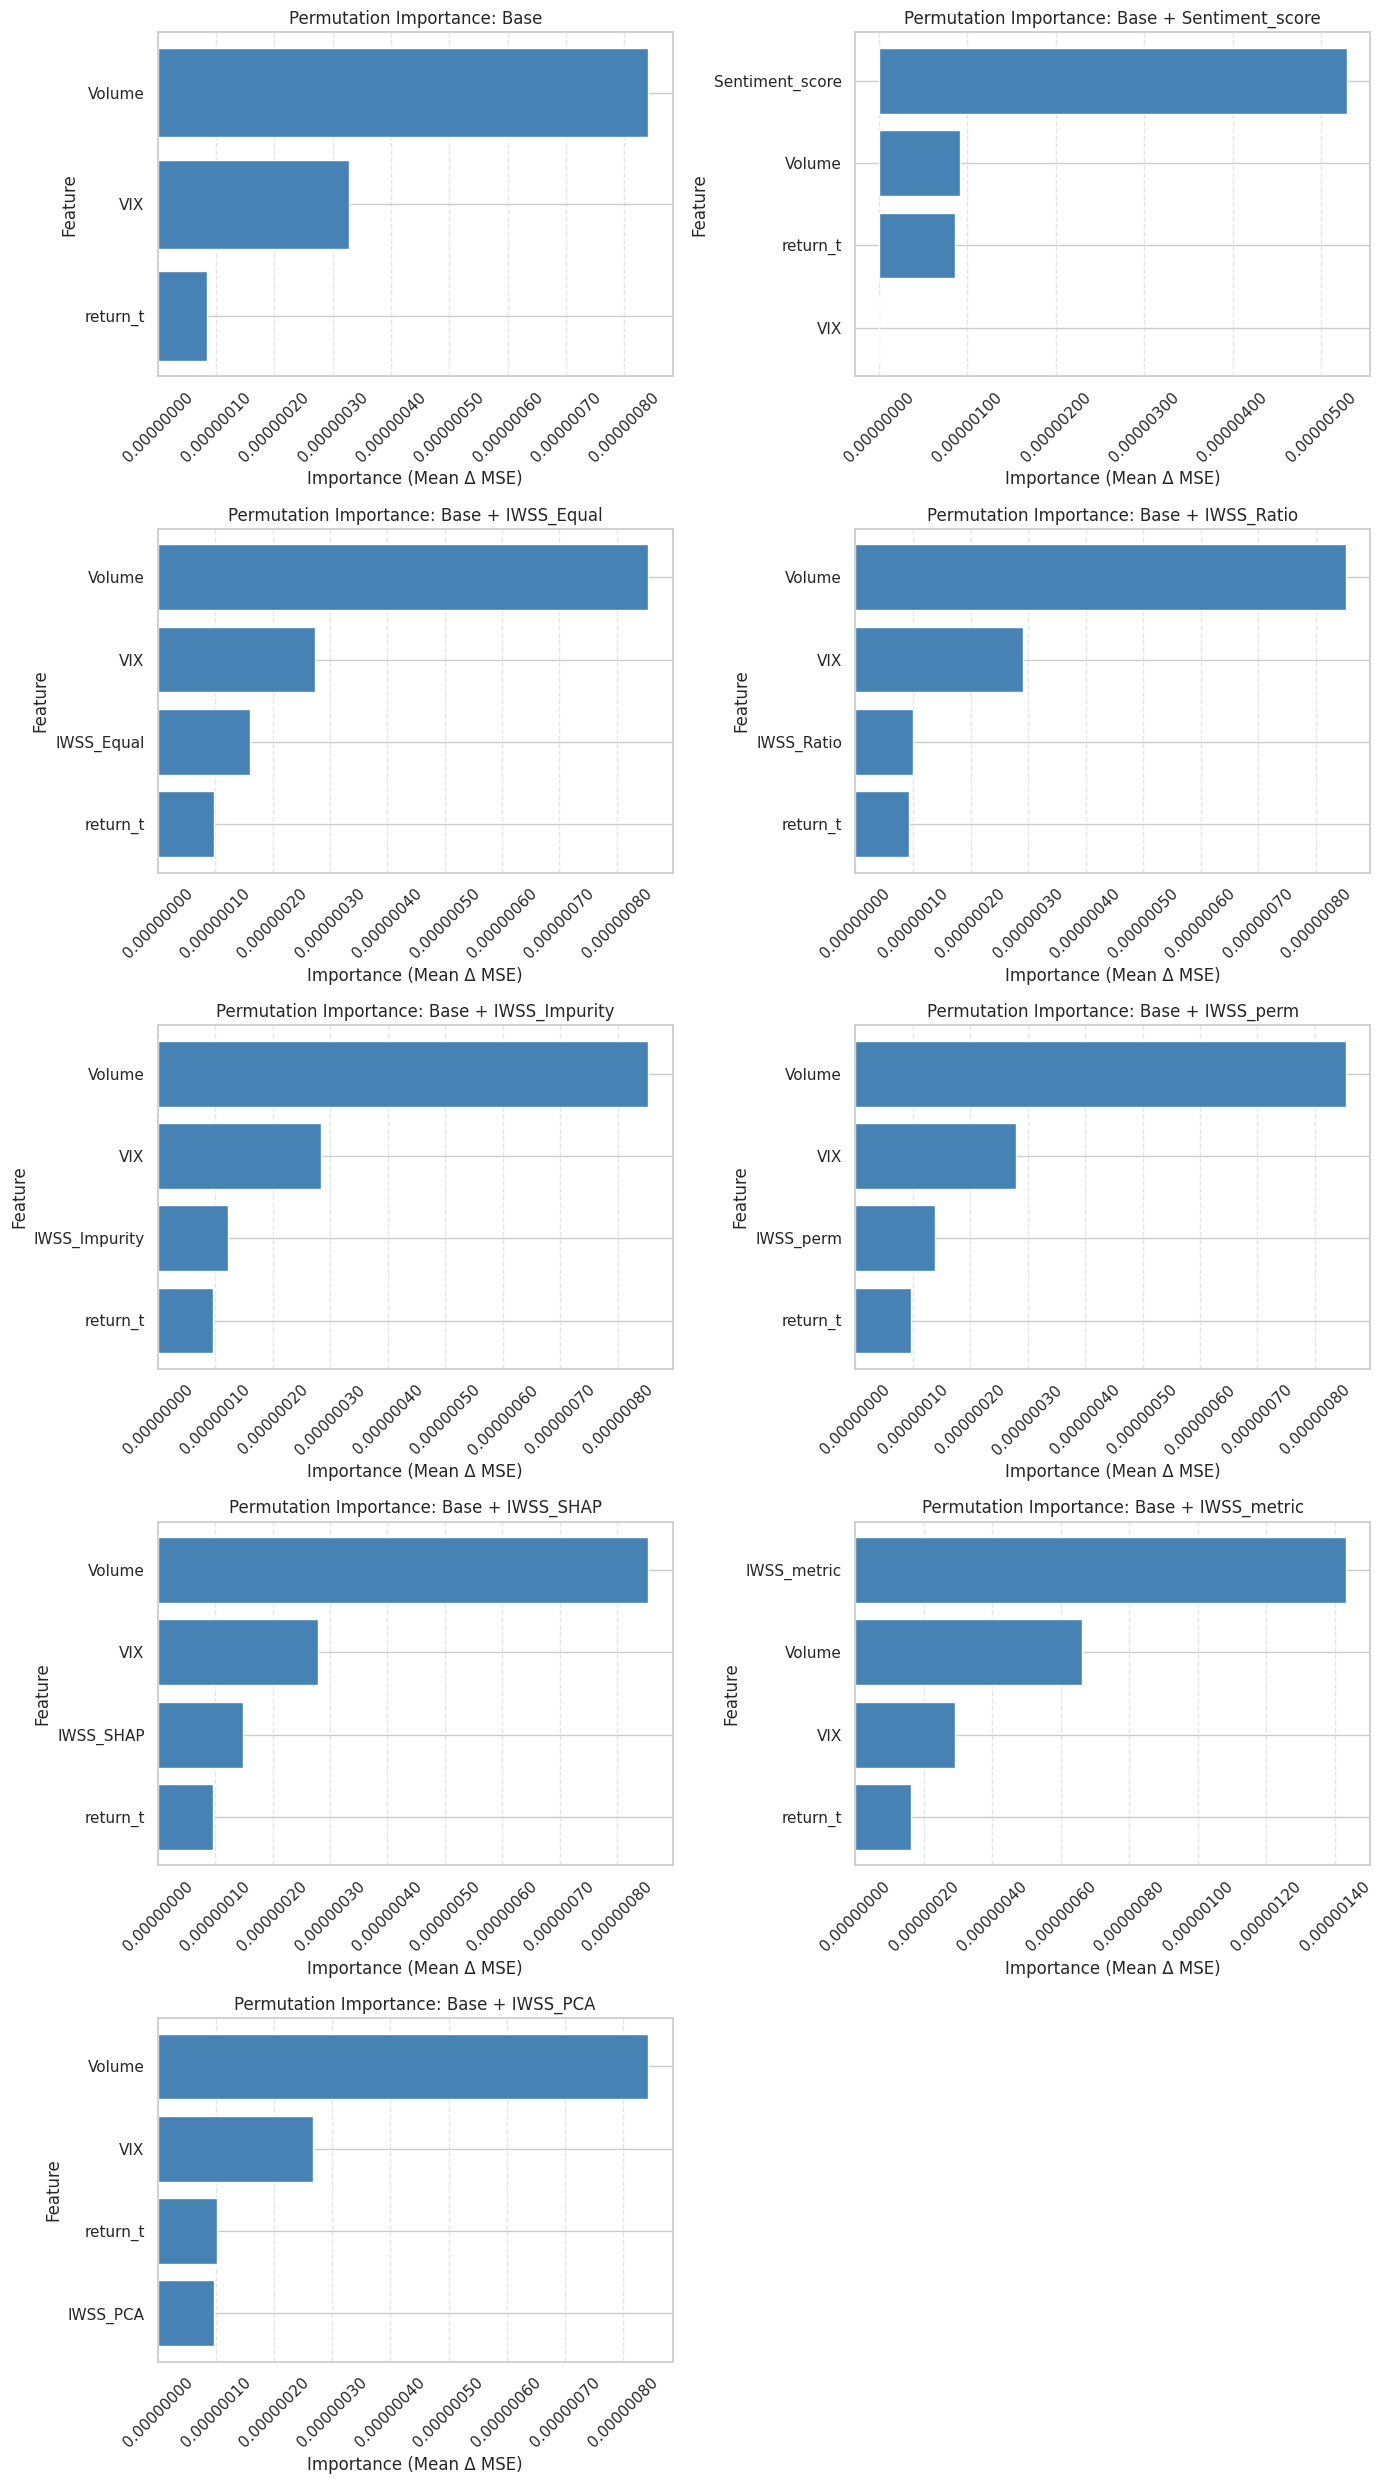

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter to show x-axis in standard decimal notation
def decimal_formatter(x, _):
    return f'{x:.8f}'  # Adjust decimal places here as needed

# Create individual bar charts per model for permutation importance
num_models = len(perm_importance_dict)
fig, axes = plt.subplots(nrows=(num_models + 1) // 2, ncols=2, figsize=(14, 5 * ((num_models + 1) // 2)))
axes = axes.flatten()

for i, (model_name, importances) in enumerate(perm_importance_dict.items()):
    ax = axes[i]
    sorted_importances = importances.sort_values(ascending=True)
    ax.barh(sorted_importances.index, sorted_importances.values, color='steelblue')
    ax.set_title(f"Permutation Importance: {model_name}", fontsize=12)
    ax.set_xlabel("Importance (Mean Δ MSE)")
    ax.set_ylabel("Feature")
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Apply decimal formatting
    ax.xaxis.set_major_formatter(FuncFormatter(decimal_formatter))
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


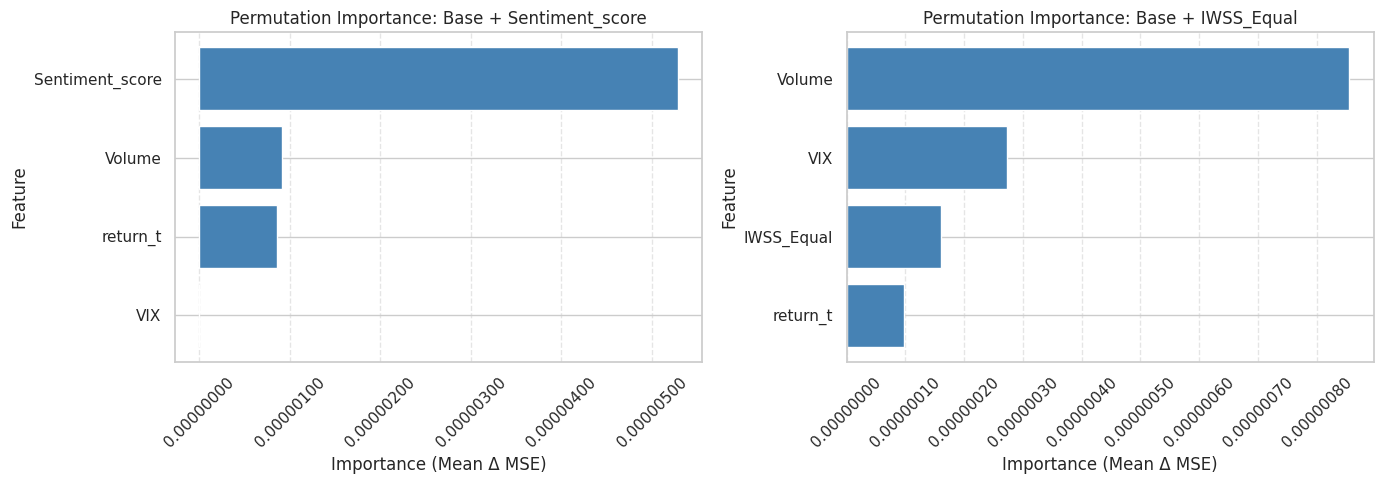

In [ ]:
import matplotlib.pyplot as plt

filtered_importance = {
    name: imp for name, imp in perm_importance_dict.items()
    if 'Sentiment_score' in name or 'IWSS_Equal' in name
}

# Custom formatter to show x-axis in standard decimal notation
def decimal_formatter(x, _):
    return f'{x:.8f}'  # Adjust decimal places here as needed

# Create individual bar charts per model for permutation importance
num_models = len(filtered_importance)
fig, axes = plt.subplots(nrows=(num_models + 1) // 2, ncols=2, figsize=(14, 5 * ((num_models + 1) // 2)))
axes = axes.flatten()

for i, (model_name, importances) in enumerate(filtered_importance.items()):
    ax = axes[i]
    sorted_importances = importances.sort_values(ascending=True)
    ax.barh(sorted_importances.index, sorted_importances.values, color='steelblue')
    ax.set_title(f"Permutation Importance: {model_name}", fontsize=12)
    ax.set_xlabel("Importance (Mean Δ MSE)")
    ax.set_ylabel("Feature")
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Apply decimal formatting
    ax.xaxis.set_major_formatter(FuncFormatter(decimal_formatter))
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# Diebold Mariano Test

### Based on MSE

In [ ]:
from scipy.stats import ttest_1samp

def diebold_mariano_test(e1, e2, crit='MSE'):
    """
    Diebold-Mariano test comparing two sets of forecast errors.
    e1, e2: forecast errors (arrays of same length)
    crit: 'MSE' or 'MAE'
    """
    e1, e2 = np.asarray(e1), np.asarray(e2)

    if crit == 'MSE':
        d = (e1 ** 2) - (e2 ** 2)
    elif crit == 'MAE':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE' or 'MAE'")

    mean_d = np.mean(d)
    std_d = np.std(d, ddof=1)
    n = len(d)

    dm_stat = mean_d / (std_d / np.sqrt(n))
    p_value = 2 * (1 - stats.t.cdf(np.abs(dm_stat), df=n-1))  # two-sided test

    return dm_stat, p_value

In [ ]:
dm_results = []
sentiment_errors = errors_dict['Sentiment_score']

for model_name, errors in errors_dict.items():
    if model_name in ['Sentiment_score', 'Base']:
        continue

    dm_stat, p_value = diebold_mariano_test(errors, sentiment_errors, crit='MSE')

    dm_results.append({
        'Model Compared': f'Base + {model_name}',
        'DM Statistic': dm_stat,
        'p-value': p_value,
        'Interpretation': 'Sentiment better' if dm_stat > 0 else 'IWSS better'
    })

dm_df = pd.DataFrame(dm_results).sort_values('p-value')
dm_df

Model Compared  DM Statistic   p-value Interpretation
1     Base + IWSS_Ratio     -3.211418  0.001625    IWSS better
2  Base + IWSS_Impurity     -3.209779  0.001634    IWSS better
3      Base + IWSS_perm     -3.206872  0.001649    IWSS better
6       Base + IWSS_PCA     -3.205776  0.001655    IWSS better
4      Base + IWSS_SHAP     -3.204385  0.001662    IWSS better
0     Base + IWSS_Equal     -3.202146  0.001674    IWSS better
5    Base + IWSS_metric     -0.815402  0.416170    IWSS better

In [ ]:
iwss_models = [name for name in errors_dict if name not in ['Base', 'Sentiment_score']]

# Pairwise Diebold-Mariano tests among IWSS models
iwss_comparisons = []

for i, model_a in enumerate(iwss_models):
    for model_b in iwss_models[i + 1:]:
        e1 = errors_dict[model_a]
        e2 = errors_dict[model_b]

        dm_stat, p_value = diebold_mariano_test(e1, e2, crit='MSE')

        iwss_comparisons.append({
            'Comparison': f'{model_a} vs. {model_b}',
            'DM Statistic': dm_stat,
            'p-value': p_value,
            'Interpretation': (
    f'{model_a} significantly better' if dm_stat > 0 and p_value < 0.05 else
    f'{model_b} significantly better' if dm_stat < 0 and p_value < 0.05 else
    'No significant difference'
)

        })

iwss_dm_df = pd.DataFrame(iwss_comparisons).sort_values('p-value')


In [ ]:
iwss_dm_df

Comparison  DM Statistic   p-value  \
4      IWSS_Equal vs. IWSS_metric     -2.592898  0.010485   
18      IWSS_SHAP vs. IWSS_metric     -2.592541  0.010496   
16      IWSS_perm vs. IWSS_metric     -2.588517  0.010614   
13  IWSS_Impurity vs. IWSS_metric     -2.582889  0.010780   
9      IWSS_Ratio vs. IWSS_metric     -2.577111  0.010954   
20       IWSS_metric vs. IWSS_PCA      2.521465  0.012760   
10        IWSS_Ratio vs. IWSS_PCA     -1.511976  0.132702   
14     IWSS_Impurity vs. IWSS_PCA     -1.377013  0.170616   
17         IWSS_perm vs. IWSS_PCA     -1.287973  0.199793   
19         IWSS_SHAP vs. IWSS_PCA     -1.254393  0.211704   
5         IWSS_Equal vs. IWSS_PCA     -1.209855  0.228290   
15        IWSS_perm vs. IWSS_SHAP      0.953101  0.342114   
12    IWSS_Impurity vs. IWSS_SHAP      0.859910  0.391248   
11    IWSS_Impurity vs. IWSS_perm      0.794520  0.428182   
8        IWSS_Ratio vs. IWSS_SHAP      0.780922  0.436113   
1    IWSS_Equal vs. IWSS_Impurity     -0.778293  0.437656   
2        IWSS_Equal vs. IWSS_perm     -0.763591  0.446343   
0       IWSS_Equal vs. IWSS_Ratio     -0.736064  0.462873   
7        IWSS_Ratio vs. IWSS_perm      0.720821  0.472172   
6    IWSS_Ratio vs. IWSS_Impurity      0.647441  0.518363   
3        IWSS_Equal vs. IWSS_SHAP     -0.464399  0.643054   

                      Interpretation  
4   IWSS_metric significantly better  
18  IWSS_metric significantly better  
16  IWSS_metric significantly better  
13  IWSS_metric significantly better  
9   IWSS_metric significantly better  
20  IWSS_metric significantly better  
10         No significant difference  
14         No significant difference  
17         No significant difference  
19         No significant difference  
5          No significant difference  
15         No significant difference  
12         No significant difference  
11         No significant difference  
8          No significant difference  
1          No significant difference  
2          No significant difference  
0          No significant difference  
7          No significant difference  
6          No significant difference  
3          No significant difference

In [ ]:
# Initialize results list
dm_results_base_vs_iwss = []

base_errors = errors_dict['Base']

for model_name, errors in errors_dict.items():
    if 'IWSS' not in model_name or model_name == 'Base':
        continue

    dm_stat, p_value = diebold_mariano_test(errors, sentiment_errors, crit='MSE')

    if dm_stat < 0 and p_value < 0.05:
        interpretation = f"{model_name} significantly better"
    elif dm_stat > 0 and p_value < 0.05:
        interpretation = "Base significantly better"
    else:
        interpretation = "No significant difference"

    dm_results_base_vs_iwss.append({
        'Model Compared': model_name,
        'DM Statistic': dm_stat,
        'p-value': p_value,
        'Interpretation': interpretation
    })


dm_df_base_vs_iwss = pd.DataFrame(dm_results_base_vs_iwss).sort_values('p-value')
dm_df_base_vs_iwss

Model Compared  DM Statistic   p-value                      Interpretation
1     IWSS_Ratio     -3.211418  0.001625     IWSS_Ratio significantly better
2  IWSS_Impurity     -3.209779  0.001634  IWSS_Impurity significantly better
3      IWSS_perm     -3.206872  0.001649      IWSS_perm significantly better
6       IWSS_PCA     -3.205776  0.001655       IWSS_PCA significantly better
4      IWSS_SHAP     -3.204385  0.001662      IWSS_SHAP significantly better
0     IWSS_Equal     -3.202146  0.001674     IWSS_Equal significantly better
5    IWSS_metric     -0.815402  0.416170           No significant difference

### Based on MAE

In [ ]:
def diebold_mariano_test(e1, e2, crit='MAE'):
    """
    Diebold-Mariano test comparing two sets of forecast errors.
    e1, e2: forecast errors (arrays of same length)
    crit: 'MSE' or 'MAE'
    """
    e1, e2 = np.asarray(e1), np.asarray(e2)

    if crit == 'MSE':
        d = (e1 ** 2) - (e2 ** 2)
    elif crit == 'MAE':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE' or 'MAE'")

    mean_d = np.mean(d)
    std_d = np.std(d, ddof=1)
    n = len(d)

    dm_stat = mean_d / (std_d / np.sqrt(n))
    p_value = 2 * (1 - stats.t.cdf(np.abs(dm_stat), df=n-1))  # two-sided test

    return dm_stat, p_value


In [ ]:
dm_results_mae = []
sentiment_errors = errors_dict['Sentiment_score']

for model_name, errors in errors_dict.items():
    if model_name in ['Sentiment_score', 'Base']:
        continue  # Skip baseline comparisons

    dm_stat, p_value = diebold_mariano_test(errors, sentiment_errors, crit='MAE')

    dm_results_mae.append({
        'Model Compared': f'Base + {model_name}',
        'DM Statistic (MAE)': dm_stat,
        'p-value (MAE)': p_value,
        'Interpretation': 'Sentiment better' if dm_stat > 0 else 'IWSS better'
    })

dm_df_mae = pd.DataFrame(dm_results_mae).sort_values(by='p-value (MAE)')
dm_df_mae

Model Compared  DM Statistic (MAE)  p-value (MAE) Interpretation
6       Base + IWSS_PCA           -4.436315       0.000018    IWSS better
0     Base + IWSS_Equal           -4.436232       0.000018    IWSS better
4      Base + IWSS_SHAP           -4.425339       0.000019    IWSS better
3      Base + IWSS_perm           -4.419068       0.000019    IWSS better
2  Base + IWSS_Impurity           -4.404229       0.000020    IWSS better
1     Base + IWSS_Ratio           -4.384044       0.000022    IWSS better
5    Base + IWSS_metric           -1.331595       0.185068    IWSS better

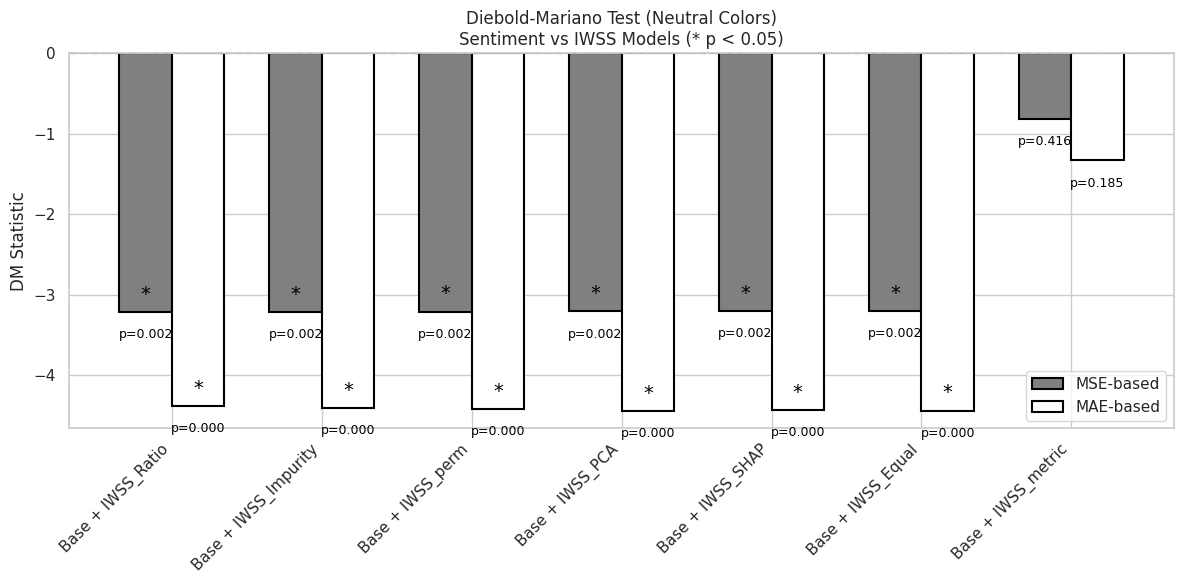

In [ ]:
dm_combined = pd.merge(
    dm_df[['Model Compared', 'DM Statistic', 'p-value']],
    dm_df_mae[['Model Compared', 'DM Statistic (MAE)', 'p-value (MAE)']],
    on='Model Compared'
)

dm_combined_sorted = dm_combined.sort_values(by='DM Statistic')
x = np.arange(len(dm_combined_sorted))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(
    x,
    dm_combined_sorted['DM Statistic'],
    width=bar_width,
    label='MSE-based',
    color='gray',
    edgecolor='black',
    linewidth=1.5
)
bars2 = ax.bar(
    x + bar_width,
    dm_combined_sorted['DM Statistic (MAE)'],
    width=bar_width,
    label='MAE-based',
    color='white',
    edgecolor='black',
    linewidth=1.5
)

# Add significance stars and p-values (MSE)
for i, (p, stat) in enumerate(zip(dm_combined_sorted['p-value'], dm_combined_sorted['DM Statistic'])):
    if p < 0.05:
        ax.text(x[i], stat + 0.1, '*', ha='center', va='bottom', fontsize=14, color='black')
    ax.text(x[i], stat - 0.2, f'p={p:.3f}', ha='center', va='top', fontsize=9, color='black')

# Add significance stars and p-values (MAE)
for i, (p, stat) in enumerate(zip(dm_combined_sorted['p-value (MAE)'], dm_combined_sorted['DM Statistic (MAE)'])):
    if p < 0.05:
        ax.text(x[i] + bar_width, stat + 0.1, '*', ha='center', va='bottom', fontsize=14, color='black')
    ax.text(x[i] + bar_width, stat - 0.2, f'p={p:.3f}', ha='center', va='top', fontsize=9, color='black')

ax.axhline(0, color='gray', linestyle='--')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(dm_combined_sorted['Model Compared'], rotation=45, ha='right')
ax.set_ylabel('DM Statistic')
ax.set_title('Diebold-Mariano Test (Neutral Colors)\nSentiment vs IWSS Models (* p < 0.05)')
ax.legend()
plt.tight_layout()
plt.show()

# Assumptions


Checking OLS Assumptions — Model: Base

[1] Linearity (Residuals vs. Predicted)


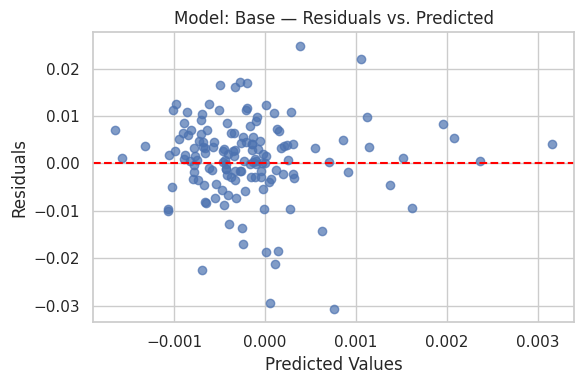


[2] Multicollinearity (VIF)
    Feature       VIF
0  return_t  1.132280
1    Volume  1.022246
2       VIX  1.143119

[3] Homoscedasticity (Breusch-Pagan Test)
{'Lagrange Multiplier stat': np.float64(8.686569298323478), 'p-value': np.float64(0.033761855953165325), 'f-value': np.float64(2.9936341042191126), 'f p-value': np.float64(0.03294949516736818)}

[4] Autocorrelation (Durbin-Watson)
Durbin-Watson Statistic: 1.918 (ideal ~2.0)

[5] Normality of Residuals


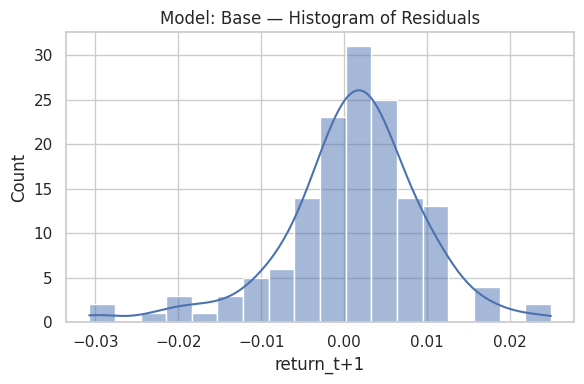

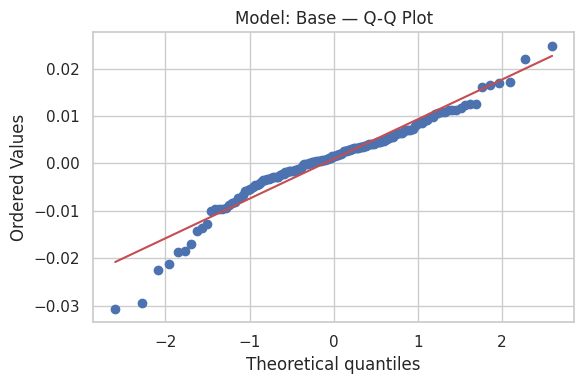

Shapiro-Wilk Test p-value: 0.0000 (p > 0.05 suggests normality)

--------------------------------------------------
Conclusion Summary — Model: Base
--------------------------------------------------
Linearity: Check residuals plot visually. Look for random scatter.
Multicollinearity: ✅ No multicollinearity concern (all VIF ≤ 3)
Homoscedasticity: ⚠️ Problem: p-value = 0.0338 (potential heteroscedasticity)
Autocorrelation: ✅ DW = 1.918 (no autocorrelation)
Normality: ⚠️ Problem: p-value = 0.0000 (non-normal residuals)

Checking OLS Assumptions — Model: Sentiment_score

[1] Linearity (Residuals vs. Predicted)


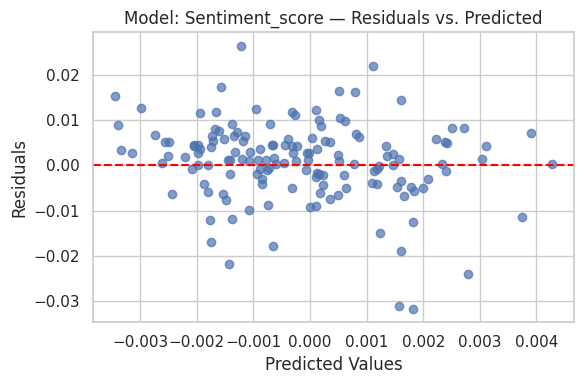


[2] Multicollinearity (VIF)
           Feature       VIF
0         return_t  1.223353
1           Volume  1.024658
2              VIX  1.214297
3  Sentiment_score  1.225557

[3] Homoscedasticity (Breusch-Pagan Test)
{'Lagrange Multiplier stat': np.float64(9.77184053154027), 'p-value': np.float64(0.04445147374423667), 'f-value': np.float64(2.527909287812102), 'f p-value': np.float64(0.04328275408782563)}

[4] Autocorrelation (Durbin-Watson)
Durbin-Watson Statistic: 1.935 (ideal ~2.0)

[5] Normality of Residuals


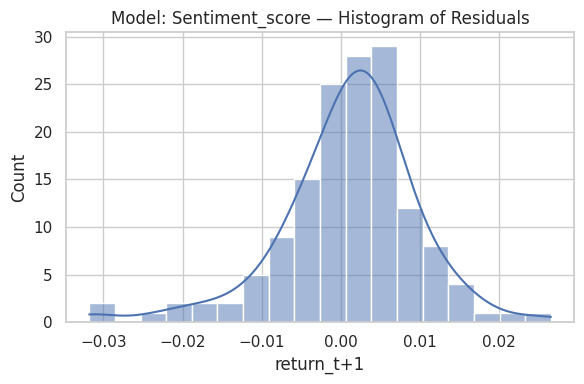

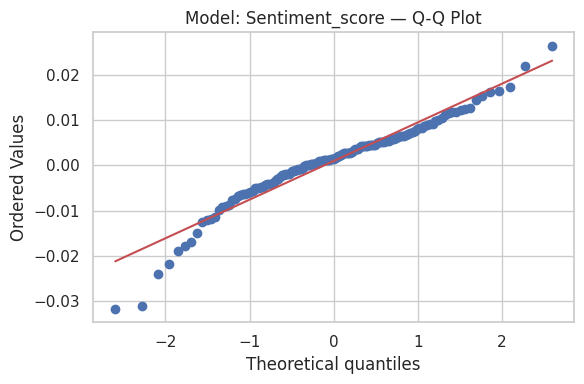

Shapiro-Wilk Test p-value: 0.0000 (p > 0.05 suggests normality)

--------------------------------------------------
Conclusion Summary — Model: Sentiment_score
--------------------------------------------------
Linearity: Check residuals plot visually. Look for random scatter.
Multicollinearity: ✅ No multicollinearity concern (all VIF ≤ 3)
Homoscedasticity: ⚠️ Problem: p-value = 0.0445 (potential heteroscedasticity)
Autocorrelation: ✅ DW = 1.935 (no autocorrelation)
Normality: ⚠️ Problem: p-value = 0.0000 (non-normal residuals)

Checking OLS Assumptions — Model: IWSS_Equal

[1] Linearity (Residuals vs. Predicted)


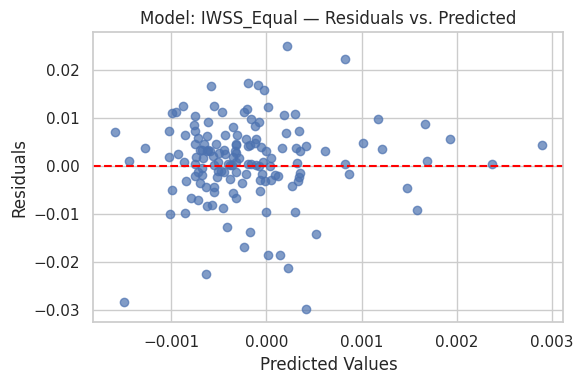


[2] Multicollinearity (VIF)
      Feature       VIF
0    return_t  1.134328
1      Volume  1.037923
2         VIX  1.159215
3  IWSS_Equal  1.033201

[3] Homoscedasticity (Breusch-Pagan Test)
{'Lagrange Multiplier stat': np.float64(16.821355691671766), 'p-value': np.float64(0.0020936781901802408), 'f-value': np.float64(4.587220355744202), 'f p-value': np.float64(0.0016330705289630254)}

[4] Autocorrelation (Durbin-Watson)
Durbin-Watson Statistic: 1.920 (ideal ~2.0)

[5] Normality of Residuals


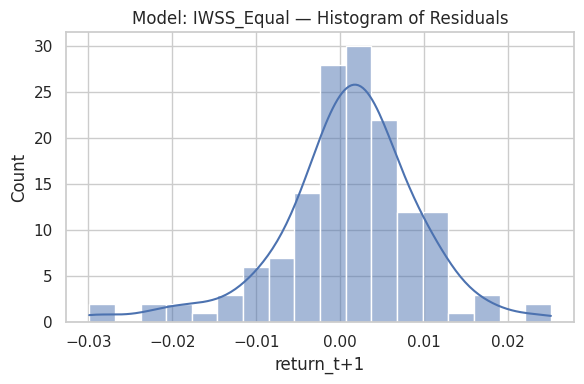

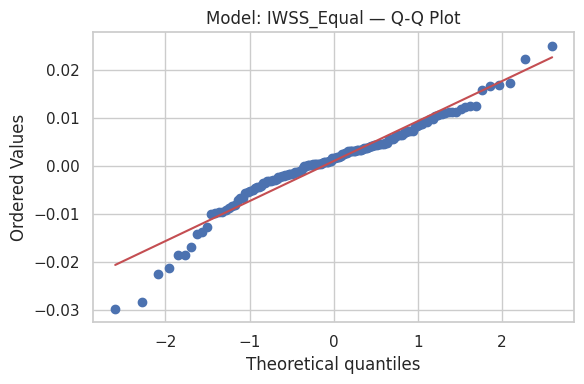

Shapiro-Wilk Test p-value: 0.0001 (p > 0.05 suggests normality)

--------------------------------------------------
Conclusion Summary — Model: IWSS_Equal
--------------------------------------------------
Linearity: Check residuals plot visually. Look for random scatter.
Multicollinearity: ✅ No multicollinearity concern (all VIF ≤ 3)
Homoscedasticity: ⚠️ Problem: p-value = 0.0021 (potential heteroscedasticity)
Autocorrelation: ✅ DW = 1.920 (no autocorrelation)
Normality: ⚠️ Problem: p-value = 0.0001 (non-normal residuals)

Checking OLS Assumptions — Model: IWSS_Ratio

[1] Linearity (Residuals vs. Predicted)


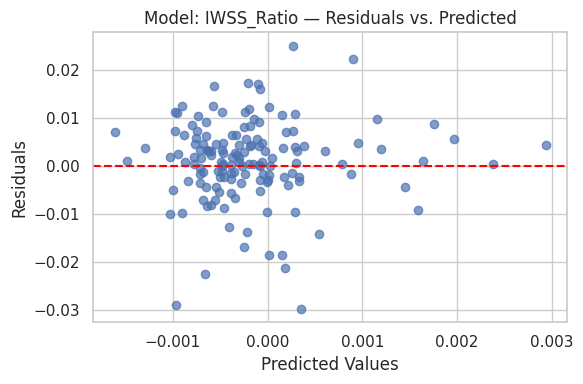


[2] Multicollinearity (VIF)
      Feature       VIF
0    return_t  1.133488
1      Volume  1.043507
2         VIX  1.155141
3  IWSS_Ratio  1.035320

[3] Homoscedasticity (Breusch-Pagan Test)
{'Lagrange Multiplier stat': np.float64(18.139333428934652), 'p-value': np.float64(0.0011590679303603792), 'f-value': np.float64(4.997229595828996), 'f p-value': np.float64(0.0008482382205532894)}

[4] Autocorrelation (Durbin-Watson)
Durbin-Watson Statistic: 1.919 (ideal ~2.0)

[5] Normality of Residuals


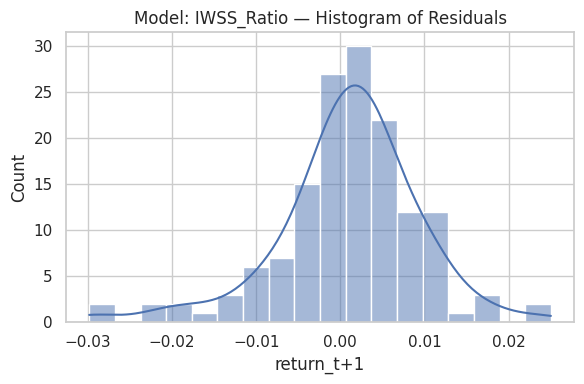

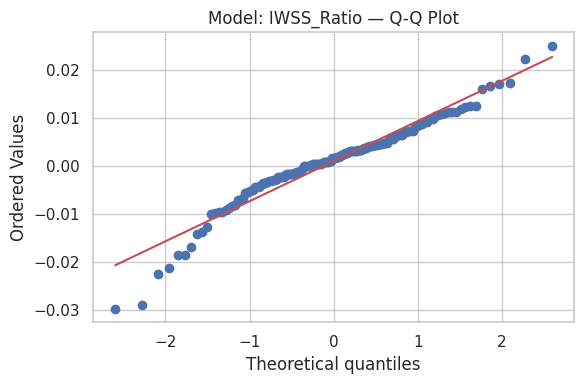

Shapiro-Wilk Test p-value: 0.0000 (p > 0.05 suggests normality)

--------------------------------------------------
Conclusion Summary — Model: IWSS_Ratio
--------------------------------------------------
Linearity: Check residuals plot visually. Look for random scatter.
Multicollinearity: ✅ No multicollinearity concern (all VIF ≤ 3)
Homoscedasticity: ⚠️ Problem: p-value = 0.0012 (potential heteroscedasticity)
Autocorrelation: ✅ DW = 1.919 (no autocorrelation)
Normality: ⚠️ Problem: p-value = 0.0000 (non-normal residuals)

Checking OLS Assumptions — Model: IWSS_Impurity

[1] Linearity (Residuals vs. Predicted)


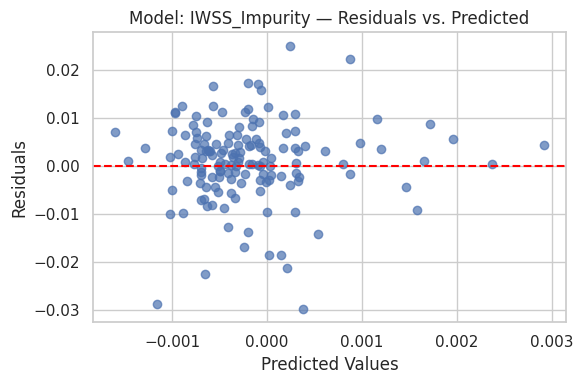


[2] Multicollinearity (VIF)
         Feature       VIF
0       return_t  1.134035
1         Volume  1.040395
2            VIX  1.157513
3  IWSS_Impurity  1.034241

[3] Homoscedasticity (Breusch-Pagan Test)
{'Lagrange Multiplier stat': np.float64(17.51574160773716), 'p-value': np.float64(0.0015341227148647572), 'f-value': np.float64(4.802196303978095), 'f p-value': np.float64(0.0011581498977935268)}

[4] Autocorrelation (Durbin-Watson)
Durbin-Watson Statistic: 1.919 (ideal ~2.0)

[5] Normality of Residuals


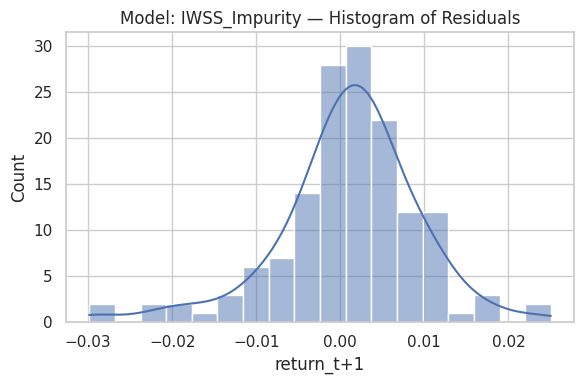

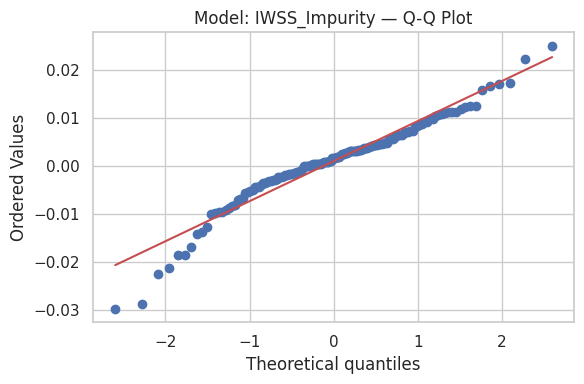

Shapiro-Wilk Test p-value: 0.0000 (p > 0.05 suggests normality)

--------------------------------------------------
Conclusion Summary — Model: IWSS_Impurity
--------------------------------------------------
Linearity: Check residuals plot visually. Look for random scatter.
Multicollinearity: ✅ No multicollinearity concern (all VIF ≤ 3)
Homoscedasticity: ⚠️ Problem: p-value = 0.0015 (potential heteroscedasticity)
Autocorrelation: ✅ DW = 1.919 (no autocorrelation)
Normality: ⚠️ Problem: p-value = 0.0000 (non-normal residuals)

Checking OLS Assumptions — Model: IWSS_perm

[1] Linearity (Residuals vs. Predicted)


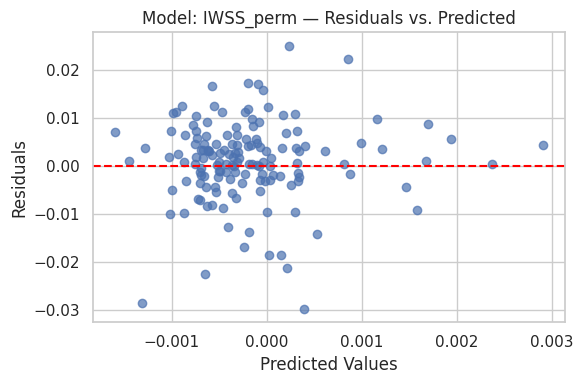


[2] Multicollinearity (VIF)
     Feature       VIF
0   return_t  1.134153
1     Volume  1.039302
2        VIX  1.158242
3  IWSS_perm  1.033766

[3] Homoscedasticity (Breusch-Pagan Test)
{'Lagrange Multiplier stat': np.float64(17.201975092127498), 'p-value': np.float64(0.001765852709912775), 'f-value': np.float64(4.7047720194815374), 'f p-value': np.float64(0.0013532559914337676)}

[4] Autocorrelation (Durbin-Watson)
Durbin-Watson Statistic: 1.919 (ideal ~2.0)

[5] Normality of Residuals


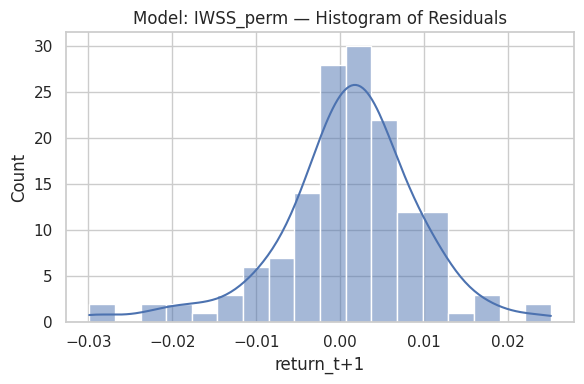

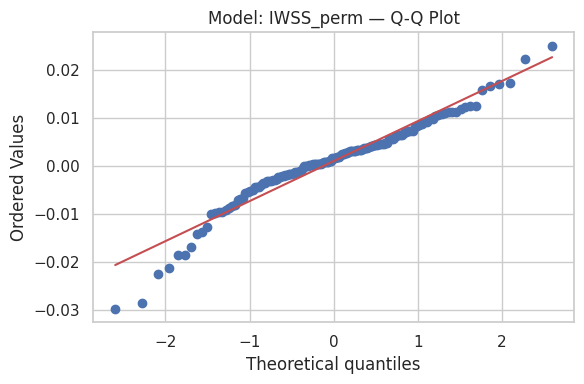

Shapiro-Wilk Test p-value: 0.0000 (p > 0.05 suggests normality)

--------------------------------------------------
Conclusion Summary — Model: IWSS_perm
--------------------------------------------------
Linearity: Check residuals plot visually. Look for random scatter.
Multicollinearity: ✅ No multicollinearity concern (all VIF ≤ 3)
Homoscedasticity: ⚠️ Problem: p-value = 0.0018 (potential heteroscedasticity)
Autocorrelation: ✅ DW = 1.919 (no autocorrelation)
Normality: ⚠️ Problem: p-value = 0.0000 (non-normal residuals)

Checking OLS Assumptions — Model: IWSS_SHAP

[1] Linearity (Residuals vs. Predicted)


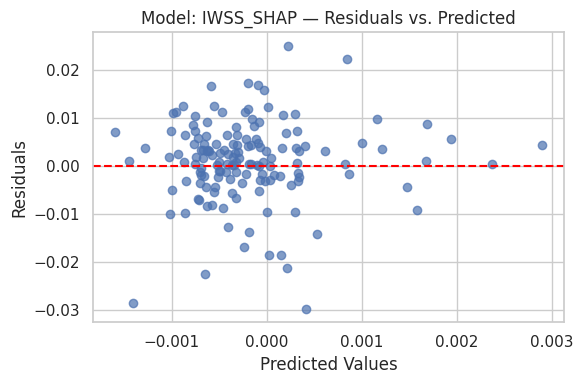


[2] Multicollinearity (VIF)
     Feature       VIF
0   return_t  1.133965
1     Volume  1.039723
2        VIX  1.157743
3  IWSS_SHAP  1.033764

[3] Homoscedasticity (Breusch-Pagan Test)
{'Lagrange Multiplier stat': np.float64(17.180612284333144), 'p-value': np.float64(0.001782829926640982), 'f-value': np.float64(4.698156006017128), 'f p-value': np.float64(0.0013676432816761978)}

[4] Autocorrelation (Durbin-Watson)
Durbin-Watson Statistic: 1.920 (ideal ~2.0)

[5] Normality of Residuals


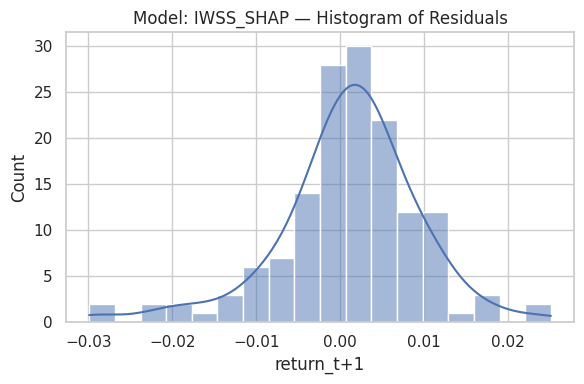

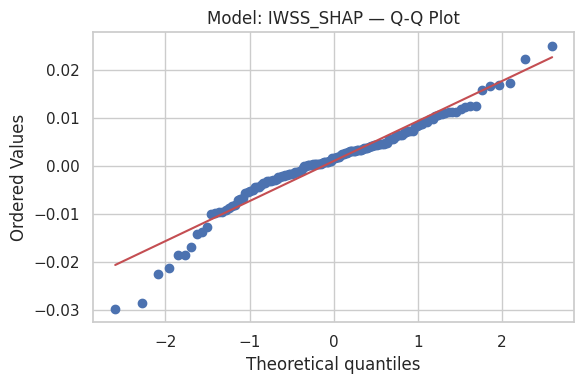

Shapiro-Wilk Test p-value: 0.0000 (p > 0.05 suggests normality)

--------------------------------------------------
Conclusion Summary — Model: IWSS_SHAP
--------------------------------------------------
Linearity: Check residuals plot visually. Look for random scatter.
Multicollinearity: ✅ No multicollinearity concern (all VIF ≤ 3)
Homoscedasticity: ⚠️ Problem: p-value = 0.0018 (potential heteroscedasticity)
Autocorrelation: ✅ DW = 1.920 (no autocorrelation)
Normality: ⚠️ Problem: p-value = 0.0000 (non-normal residuals)

Checking OLS Assumptions — Model: IWSS_metric

[1] Linearity (Residuals vs. Predicted)


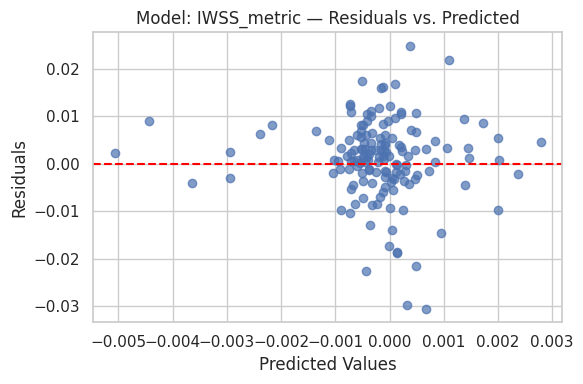


[2] Multicollinearity (VIF)
       Feature       VIF
0     return_t  1.134086
1       Volume  1.022380
2          VIX  1.154249
3  IWSS_metric  1.009800

[3] Homoscedasticity (Breusch-Pagan Test)
{'Lagrange Multiplier stat': np.float64(10.374345683019039), 'p-value': np.float64(0.03457257334609961), 'f-value': np.float64(2.695608475496989), 'f p-value': np.float64(0.033280293961156907)}

[4] Autocorrelation (Durbin-Watson)
Durbin-Watson Statistic: 1.939 (ideal ~2.0)

[5] Normality of Residuals


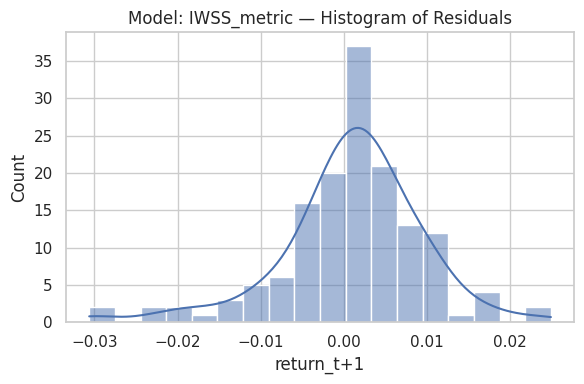

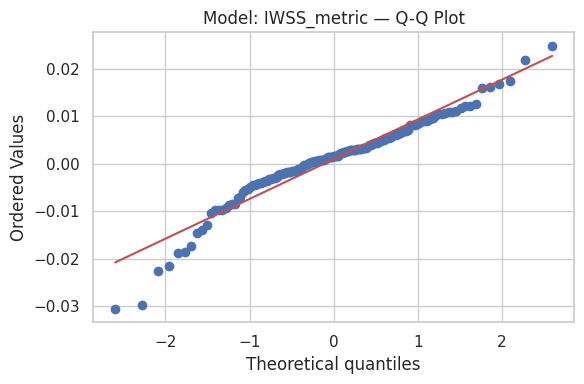

Shapiro-Wilk Test p-value: 0.0000 (p > 0.05 suggests normality)

--------------------------------------------------
Conclusion Summary — Model: IWSS_metric
--------------------------------------------------
Linearity: Check residuals plot visually. Look for random scatter.
Multicollinearity: ✅ No multicollinearity concern (all VIF ≤ 3)
Homoscedasticity: ⚠️ Problem: p-value = 0.0346 (potential heteroscedasticity)
Autocorrelation: ✅ DW = 1.939 (no autocorrelation)
Normality: ⚠️ Problem: p-value = 0.0000 (non-normal residuals)

Checking OLS Assumptions — Model: IWSS_PCA

[1] Linearity (Residuals vs. Predicted)


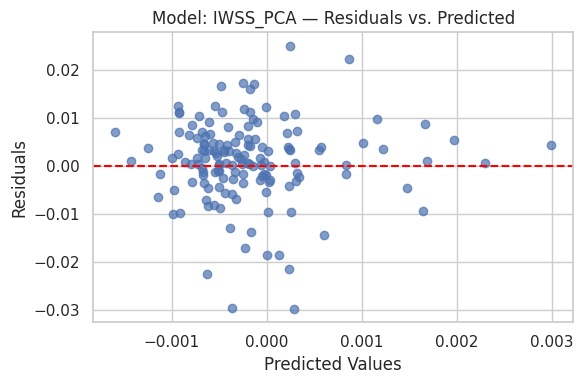


[2] Multicollinearity (VIF)
    Feature       VIF
0  return_t  1.142405
1    Volume  1.024427
2       VIX  1.167700
3  IWSS_PCA  1.027321

[3] Homoscedasticity (Breusch-Pagan Test)
{'Lagrange Multiplier stat': np.float64(10.300731655493433), 'p-value': np.float64(0.03565541452711604), 'f-value': np.float64(2.675039729169933), 'f p-value': np.float64(0.0343731999038301)}

[4] Autocorrelation (Durbin-Watson)
Durbin-Watson Statistic: 1.922 (ideal ~2.0)

[5] Normality of Residuals


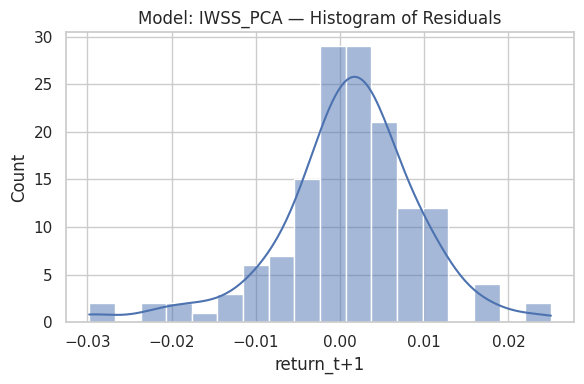

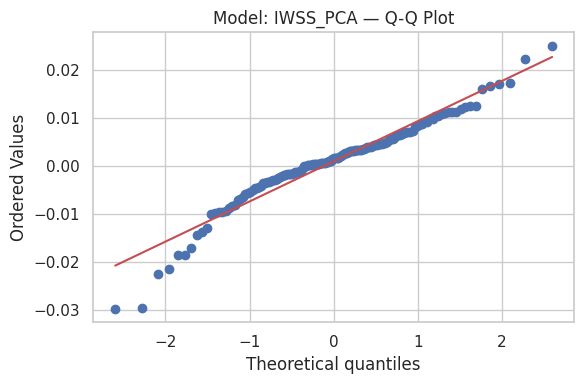

Shapiro-Wilk Test p-value: 0.0000 (p > 0.05 suggests normality)

--------------------------------------------------
Conclusion Summary — Model: IWSS_PCA
--------------------------------------------------
Linearity: Check residuals plot visually. Look for random scatter.
Multicollinearity: ✅ No multicollinearity concern (all VIF ≤ 3)
Homoscedasticity: ⚠️ Problem: p-value = 0.0357 (potential heteroscedasticity)
Autocorrelation: ✅ DW = 1.922 (no autocorrelation)
Normality: ⚠️ Problem: p-value = 0.0000 (non-normal residuals)


In [ ]:
for model_name, model in models.items():
    # Extract the feature used in this model
    if model_name == 'Base':
        features = base_features
    else:
        # Assumes format: 'Base + FEATURE'
        suffix = model_name.replace('Base + ', '').strip()
        features = base_features + [suffix]

    # Prepare data
    X = df_test[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Predict and compute residuals
    y_pred = model.predict(X_scaled)
    residuals = y_test - y_pred

    # Run diagnostics
    check_ols_assumptions(
        X_scaled,
        y_test,
        y_pred,
        residuals,
        feature_names=X.columns.tolist(),
        label=model_name
    )

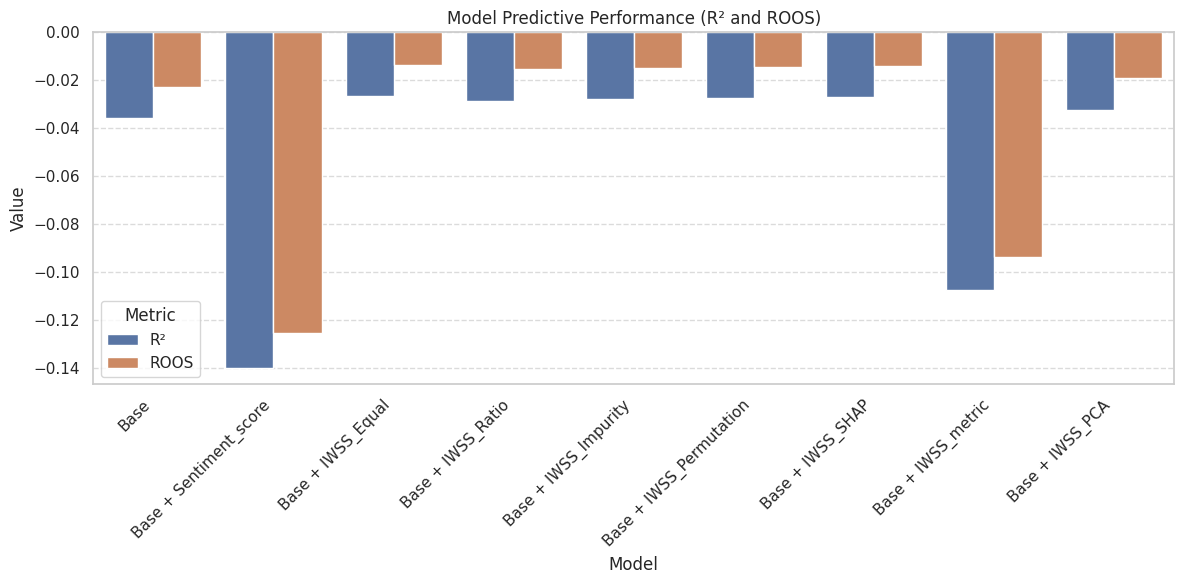

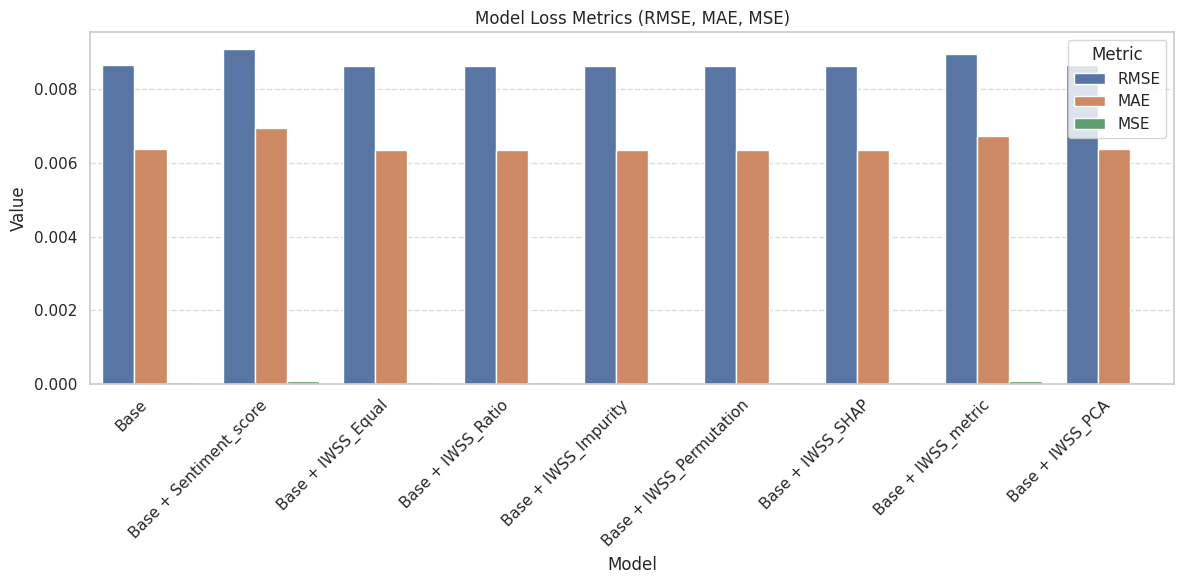

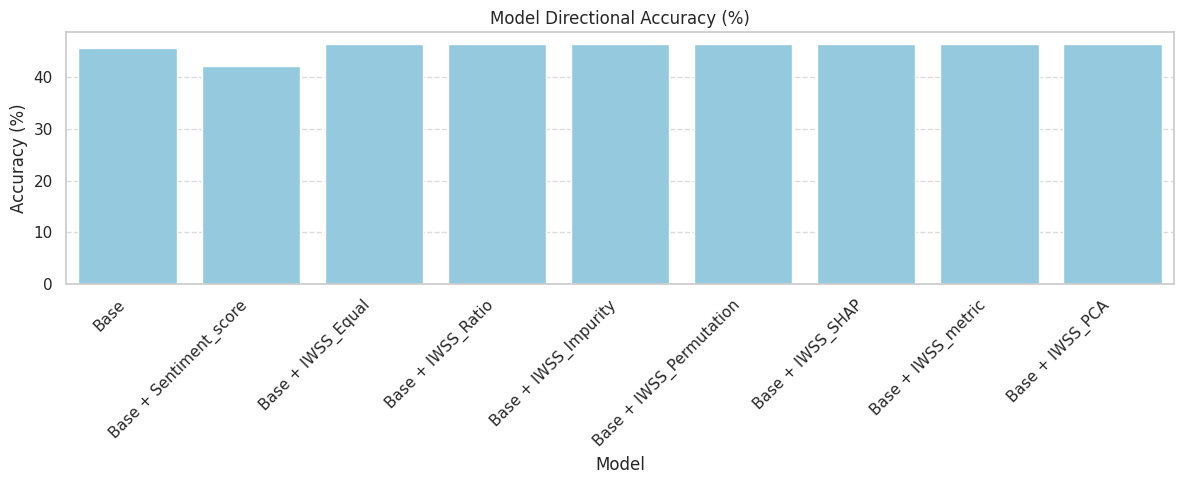

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Create the dataframe
data = {
    "Model": [
        "Base", "Base + Sentiment_score", "Base + IWSS_Equal", "Base + IWSS_Ratio",
        "Base + IWSS_Impurity", "Base + IWSS_Permutation", "Base + IWSS_SHAP",
        "Base + IWSS_metric", "Base + IWSS_PCA"
    ],
    "R²": [
        -0.035922, -0.139929, -0.026776, -0.028458, -0.027968, -0.027393, -0.026939, -0.107717, -0.032321
    ],
    "ROOS": [
        -0.022826, -0.125518, -0.013796, -0.015456, -0.014972, -0.014405, -0.013956, -0.093713, -0.01927
    ],
    "RMSE": [
        0.008657, 0.009082, 0.008619, 0.008626, 0.008624, 0.008622, 0.00862, 0.008952, 0.008642
    ],
    "MAE": [
        0.006369, 0.006936, 0.00635, 0.006354, 0.006352, 0.006351, 0.00635, 0.006726, 0.006362
    ],
    "MSE": [
        0.000075, 0.000082, 0.000074, 0.000074, 0.000074, 0.000074, 0.000074, 0.00008, 0.000075
    ],
    "Directional Accuracy (%)": [
        45.578231, 42.176871, 46.258503, 46.258503, 46.258503, 46.258503, 46.258503, 46.258503, 46.258503
    ]
}

df = pd.DataFrame(data)

# Display the table
df

# First, plot R² and ROOS (performance metrics)
plt.figure(figsize=(12, 6))
metrics_perf = ["R²", "ROOS"]
df_perf_melted = df.melt(id_vars="Model", value_vars=metrics_perf, var_name="Metric", value_name="Value")

sns.barplot(data=df_perf_melted, x="Model", y="Value", hue="Metric")
plt.xticks(rotation=45, ha='right')
plt.title("Model Predictive Performance (R² and ROOS)")
plt.ylabel("Value")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.show()

# Next, plot loss metrics (RMSE, MAE, MSE)
plt.figure(figsize=(12, 6))
metrics_loss = ["RMSE", "MAE", "MSE"]
df_loss_melted = df.melt(id_vars="Model", value_vars=metrics_loss, var_name="Metric", value_name="Value")

sns.barplot(data=df_loss_melted, x="Model", y="Value", hue="Metric")
plt.xticks(rotation=45, ha='right')
plt.title("Model Loss Metrics (RMSE, MAE, MSE)")
plt.ylabel("Value")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.show()

# Finally, plot Directional Accuracy separately
plt.figure(figsize=(12, 5))
sns.barplot(data=df, x="Model", y="Directional Accuracy (%)", color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Model Directional Accuracy (%)")
plt.ylabel("Accuracy (%)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


NameError: name 'X_test_scaled' is not defined